# Preparation du dataset

In [407]:
# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorboard.plugins.hparams import api as hp

In [107]:
# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler

In [138]:
# Data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (23,10)

In [4]:
from db import Database

In [247]:
# get dataset
db = Database()
dbConnection = db.engine.connect()
df_info = pd.read_sql("select * from \"companies\"", dbConnection)
df_timeseries = pd.read_sql("select * from \"companies_prices\"", dbConnection)
pd.set_option('display.expand_frame_repr', False)
dbConnection.close();

DB instance created
2020-09-09 19:55:06,120 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-09-09 19:55:06,122 INFO sqlalchemy.engine.base.Engine {'name': 'select * from "companies"'}
2020-09-09 19:55:06,126 INFO sqlalchemy.engine.base.Engine select * from "companies"
2020-09-09 19:55:06,127 INFO sqlalchemy.engine.base.Engine {}
2020-09-09 19:55:06,136 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-09-09 19:55:06,137 INFO sqlalchemy.engine.base.Engine {'name': 'select * from "companies_prices"'}
2020-09-09 19:55:06,139 INFO sqlalchemy.engine.base.Engine select * from "companies_prices"
2020-09-09 19:55:06,140 INFO sqlalchemy.engine.base.Engine {}


In [248]:
# Print the DataFrame
df_info.head()

id symbol    asset_type          official_name                                company_description exchange currency country              sector                   industry                                    company_address  employees     market_cap
0   1   MSFT  Common Stock  Microsoft Corporation  Microsoft Corporation develops, licenses, and ...   NASDAQ      USD     USA          Technology     SoftwareInfrastructure  One Microsoft Way, Redmond, WA, United States,...     163000  1560676401152
1   2   AAPL  Common Stock              Apple Inc  Apple Inc. designs, manufactures, and markets ...   NASDAQ      USD     USA          Technology       Consumer Electronics  One Apple Park Way, Cupertino, CA, United Stat...     137000  1990730973184
2   3      V  Common Stock               Visa Inc  Visa Inc. operates as a payments technology co...     NYSE      USD     USA  Financial Services            Credit Services  One Market Plaza, San Francisco, CA, United St...      19500   441986023424
3   4    JPM  Common Stock    JPMorgan Chase & Co  JPMorgan Chase & Co. operates as a financial s...     NYSE      USD     USA  Financial Services           BanksDiversified  383 Madison Avenue, New York, NY, United State...     256710   304516202496
4   5    JNJ  Common Stock      Johnson & Johnson  Johnson & Johnson researches and develops, man...     NYSE      USD     USA          Healthcare  Drug ManufacturersGeneral  One Johnson & Johnson Plaza, New Brunswick, NJ...     132200   401079992320

In [249]:
df_timeseries.head()

id symbol  record_day  open_price      high       low  close_price    volume
0   1   MSFT  2020-09-08      206.50  210.0300  202.2000       202.66  52924330
1   2   MSFT  2020-09-04      215.10  218.3599  205.1900       214.25  59664072
2   3   MSFT  2020-09-03      229.27  229.3100  214.9602       217.30  58400288
3   4   MSFT  2020-09-02      227.97  232.8600  227.3500       231.65  34080839
4   5   MSFT  2020-09-01      225.51  227.4500  224.4300       227.27  25791235

In [250]:
df_timeseries.describe()

id     open_price           high            low    close_price        volume
count  149213.000000  149213.000000  149213.000000  149213.000000  149213.000000  1.492130e+05
mean    74607.000000      78.636744      79.441357      77.813337      55.781406  1.325173e+07
std     43074.227196      60.767285      61.317783      60.178801      49.734636  1.807965e+07
min         1.000000       8.450000       9.210000       8.120000       0.202400  1.000000e+02
25%     37304.000000      40.540000      41.000000      40.020000      22.302500  3.802918e+06
50%     74607.000000      61.000000      61.690000      60.350000      39.162800  6.979200e+06
75%    111910.000000      96.540000      97.520000      95.630000      71.878200  1.387310e+07
max    149213.000000     702.410000     705.070000     699.570000     430.348000  6.166205e+08

In [251]:
print(df_timeseries.isna().sum()) # no missing values
print(df_info.isna().sum())

id             0
symbol         0
record_day     0
open_price     0
high           0
low            0
close_price    0
volume         0
dtype: int64
id                     0
symbol                 0
asset_type             0
official_name          0
company_description    0
exchange               0
currency               0
country                0
sector                 0
industry               0
company_address        0
employees              0
market_cap             0
dtype: int64


In [262]:
def get_time_series_graph(symbol):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    
    company = df_info["official_name"].loc[df_info["symbol"] == symbol].values[0]
    
    # dates
    dates = df_timeseries["record_day"].loc[df_timeseries["symbol"] == symbol]
    
    # open - close
    stock_open = df_timeseries["open_price"].loc[df_timeseries["symbol"] == symbol]
    stock_close = df_timeseries["close_price"].loc[df_timeseries["symbol"] == symbol]
    
    ax1.plot(dates, stock_open, label=f"{symbol} stock - Open")
    ax1.plot(dates, stock_close, label=f"{symbol} stock - Close")
    ax1.set_xlabel('Date',fontsize=18)
    ax1.set_ylabel('Price',fontsize=18)
    ax1.set_title(f"{company} - Opening/Closing Prices")
    ax1.legend()
    
    # high - low
    stock_high = df_timeseries["high"].loc[df_timeseries["symbol"] == symbol]
    stock_low = df_timeseries["low"].loc[df_timeseries["symbol"] == symbol]
    ax2.plot(dates, (stock_high + stock_low) / 2)
    ax2.set_xlabel('Date',fontsize=18)
    ax2.set_ylabel('Mid Price',fontsize=18)
    ax2.set_title(f"{company} - Mid Price")
    
    plt.show()

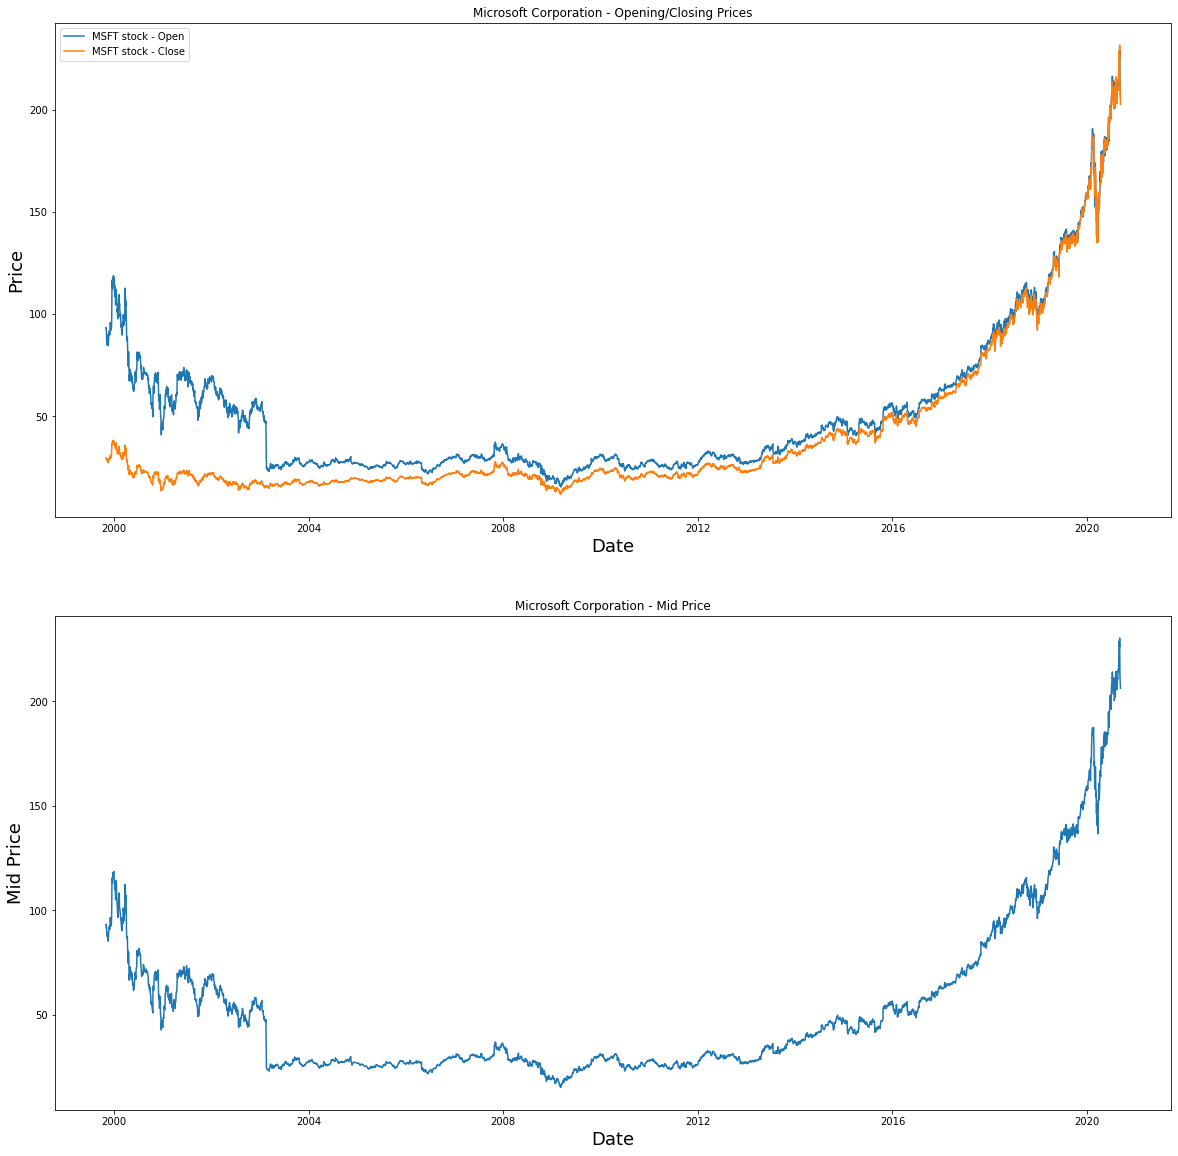

In [263]:
# with some equity symbol we can see that the values collected are OK
get_time_series_graph("MSFT")

## How to prepare data for LSTM modeling ?

We will predict the average price : (high + low) / 2 for a company stock.

For our experimentation, we took the **MSFT** stock and saw several ways to improve the model.

### Split Data

We observe the dataset is going from the newest values to farthest ones. So we will reverse the order before doing the preprocessing.

In [389]:
symbol = "MSFT"
prices_df = df_timeseries[["record_day", "high", "low"]].loc[df_timeseries["symbol"] == symbol]
prices_df = prices_df.sort_values(by='record_day').reset_index()
prices_df.drop("index", inplace=True, axis=1)
dates = prices_df["record_day"]
avg_prices = (prices_df["high"] + prices_df["low"]) / 2

### Prepare data

In [391]:
# split 80 / 20
train_size = int(avg_prices.shape[0]*0.80)
train_data = avg_prices[:train_size].values
test_data = avg_prices[train_size:].values

# get input / output for LSTM modeling
X_train, y_train, scaler = create_dataset(train_data, time_steps, normalize=False)
X_test, y_test, scaler = create_dataset(test_data, time_steps, normalize=False)

### Normalization

We normalize data by frame since the data from 20 years can be really different from the data from now.

**BUT I don't know how to apply it yet to our data**

In [366]:
def normalize_data(data, scaler):
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data)
    normalized_data = scaler.transform(data)
    return normalized_data, scaler

In [362]:
def create_dataset(X, time_steps=1, normalize=False, test_scaler = None):
    Xs, ys = [], []
    scaler = None
    
    for i in range(len(X) - time_steps):
        data = X[i:(i + time_steps)].reshape(-1, 1)
        if normalize:
            v, scaler = normalize_data(data, test_scaler)
        else:
            v = data
        Xs.append(v)
        ys.append(X[i + time_steps])
        
    return np.array(Xs), np.array(ys), scaler

In [373]:
# shape dataset : [samples, time_steps, n_features], [output]
X_test.shape, y_test.shape

((1047, 3, 1), (1047,))

### Training

We will experiment with an LSTM model

In [403]:
model = Sequential()
model.add(LSTM(units=180, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [393]:
# fit model
history = model.fit(
    X_train, 
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False)

Epoch 1/30
236/236 [==============================] - 1s 5ms/step - loss: 304.9675 - val_loss: 1.6385
Epoch 2/30
236/236 [==============================] - 1s 4ms/step - loss: 3.5096 - val_loss: 1.2974
Epoch 3/30
236/236 [==============================] - 1s 4ms/step - loss: 2.2553 - val_loss: 1.1397
Epoch 4/30
236/236 [==============================] - 1s 4ms/step - loss: 1.9601 - val_loss: 1.0321
Epoch 5/30
236/236 [==============================] - 1s 4ms/step - loss: 2.1406 - val_loss: 1.0491
Epoch 6/30
236/236 [==============================] - 1s 4ms/step - loss: 2.2315 - val_loss: 1.0349
Epoch 7/30
236/236 [==============================] - 1s 4ms/step - loss: 2.3394 - val_loss: 1.0244
Epoch 8/30
236/236 [==============================] - 1s 4ms/step - loss: 2.4342 - val_loss: 1.0145
Epoch 9/30
236/236 [==============================] - 1s 4ms/step - loss: 2.5059 - val_loss: 0.9959
Epoch 10/30
236/236 [==============================] - 1s 4ms/step - loss: 2.5339 - val_loss: 0.98

### Plot history loss

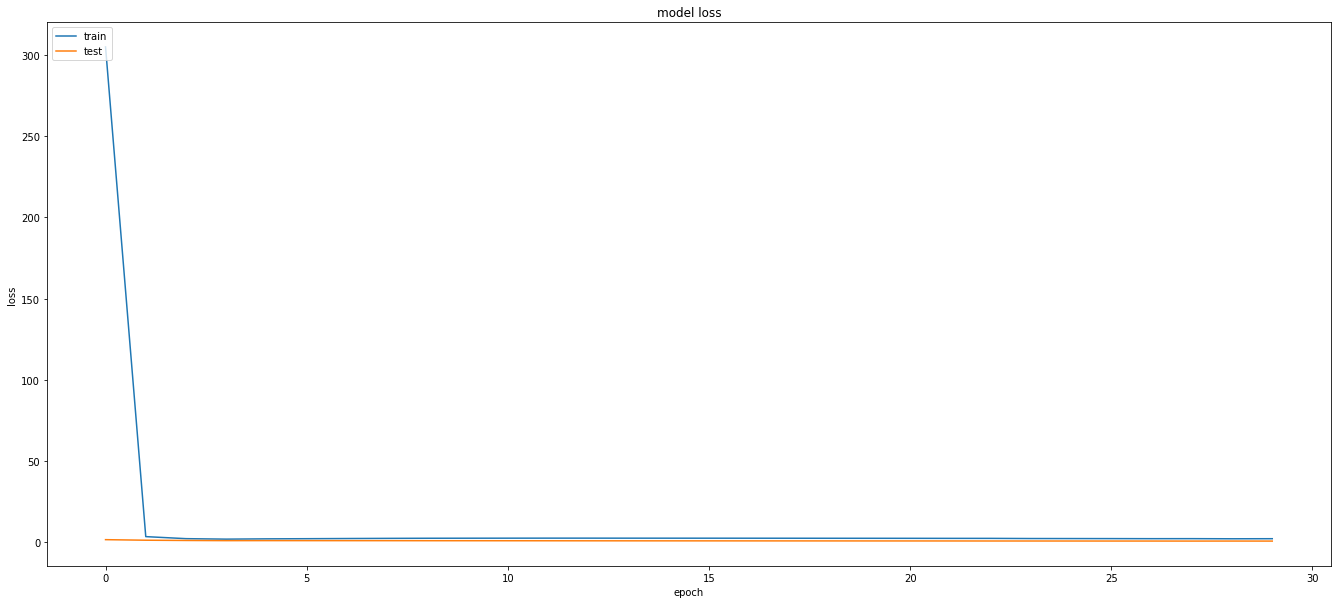

In [394]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Plot predictions

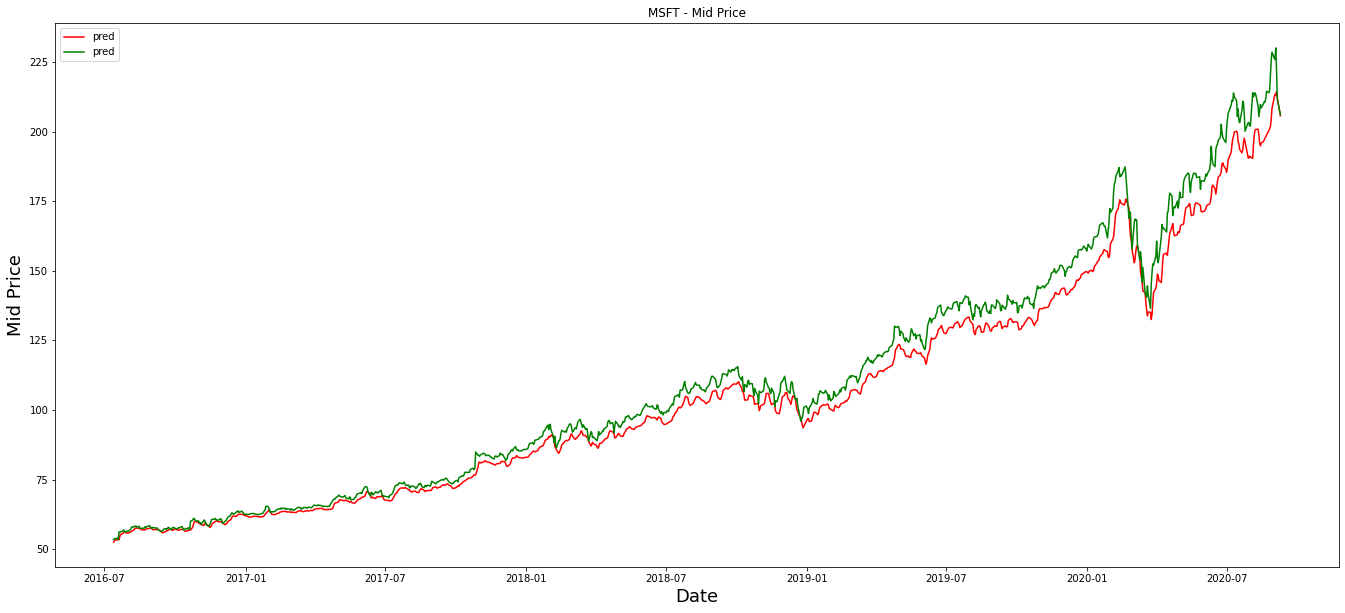

In [395]:
# plot predictions
y_pred = model.predict(X_test)
# plt.plot(dates, mid_prices, label="true", color="black")
plt.plot(dates[train_size+time_steps:], y_pred, label="pred", color="r")
plt.plot(dates[train_size+time_steps:], y_test, label="pred", color="g")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.title(f"{symbol} - Mid Price")
plt.legend()
plt.show()

### Results for Microsoft 

**Vanilla LSTM with prices over 100 days** : 
On the last epoch, we have : loss: 21.4484 - val_loss: 5.8649, which is not really good. We don't have enough data, so we will fetch more. 

**Vanilla LSTM with prices over 20 years**: 
On the last epoch, we have : loss: 2.0751 - val_loss: 0.7876. It is way better but we notice a translation of the prediction curve. We can change the hyper-parameters to improve the model.

## Generalize to other companies

We refactor the code in order to use it for any company in our dataset.

In [381]:
def get_avg_prices(symbol, df):
    prices_df = df[["record_day", "high", "low"]].loc[df["symbol"] == symbol]
    prices_df = prices_df.sort_values(by='record_day').reset_index()
    prices_df.drop("index", inplace=True, axis=1)
    dates = prices_df["record_day"]
    avg_prices = (prices_df["high"] + prices_df["low"]) / 2
    
    return avg_prices, dates

In [447]:
def prepare_data(symbol, df, time_steps=3):
    # get avg prices
    avg_prices, dates = get_avg_prices(symbol, df)
    
    # split 80 / 20
    train_size = int(avg_prices.shape[0]*0.80)
    train_data = avg_prices[:train_size].values
    test_data = avg_prices[train_size:].values
    
    # get input / output for LSTM modeling
    X_train, y_train, scaler= create_dataset(train_data, time_steps, normalize=False)
    X_test, y_test, scaler = create_dataset(test_data, time_steps, normalize=False)
    
    return X_train, y_train, X_test, y_test, dates, train_size

On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations. So we will try a vanilla LSTM and bidirectional LSTM and we will see how it comes out.

In [448]:
def plot_predictions(symbol, X_test, y_test, dates, train_size):
    y_pred = model.predict(X_test)
    # plt.plot(dates, mid_prices, label="true", color="black")
    plt.plot(dates[train_size+time_steps:], y_pred, label="pred", color="r")
    plt.plot(dates[train_size+time_steps:], y_test, label="pred", color="g")
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Mid Price',fontsize=18)
    plt.title(f"{symbol} - Mid Price")
    plt.legend()
    plt.show()

In [455]:
def run_model(X_train, y_train, X_test, y_test, dates, symbol, train_size, bidirectional=False, plot=False):
    # Create model
    model = Sequential()
    
    if bidirectional:
        model.add(LSTM(units=180, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(Bidirectional(LSTM(180, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # fit model
    history = model.fit(
        X_train, 
        y_train,
        epochs=30,
        batch_size=16,
        validation_split=0.1,
        verbose=1,
        shuffle=False)

    if plot:
         # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        plot_predictions(symbol, X_test, y_test, dates, train_size)
    
    return model

In [451]:
X_train, y_train, X_test, y_test, dates, train_size = prepare_data("MSFT", df_timeseries, time_steps=3)

Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 226.3473 - val_loss: 1.6163
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 3.6319 - val_loss: 1.2131
Epoch 3/30
236/236 [==============================] - 1s 6ms/step - loss: 2.1813 - val_loss: 1.0062
Epoch 4/30
236/236 [==============================] - 1s 6ms/step - loss: 1.7759 - val_loss: 0.8552
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 1.6870 - val_loss: 0.8219
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 1.7406 - val_loss: 0.8078
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 1.8829 - val_loss: 0.7994
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 1.9705 - val_loss: 0.8031
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 2.1199 - val_loss: 0.8052
Epoch 10/30
236/236 [==============================] - 1s 5ms/step - loss: 2.1624 - val_loss: 0.80

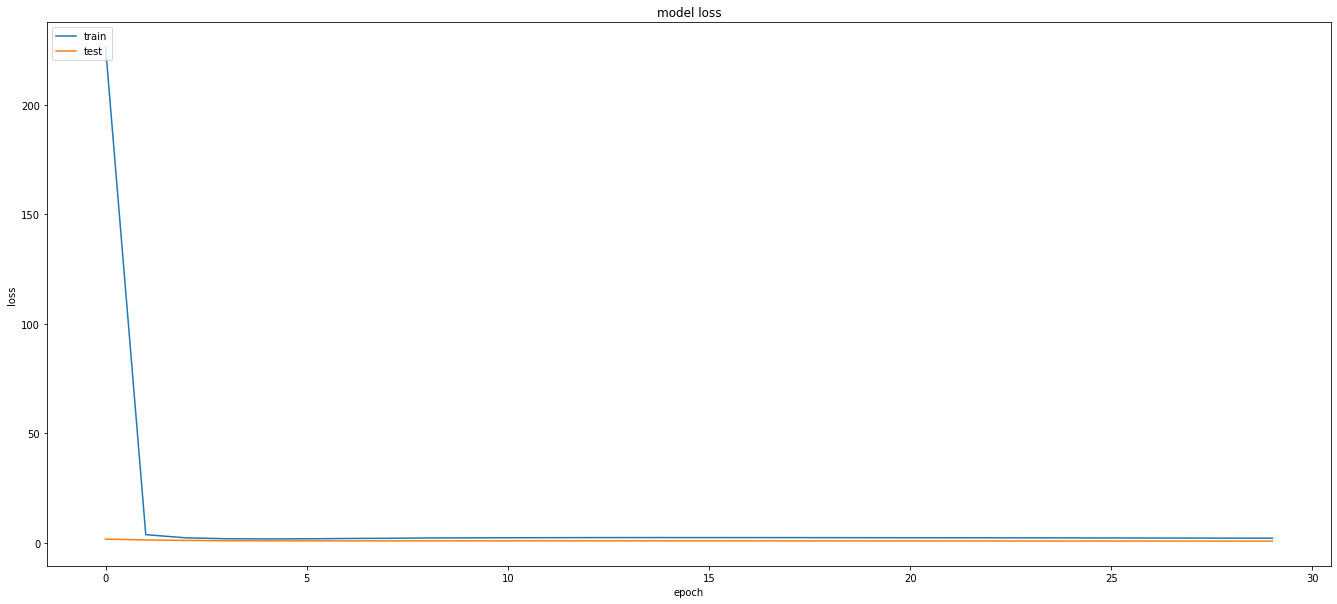

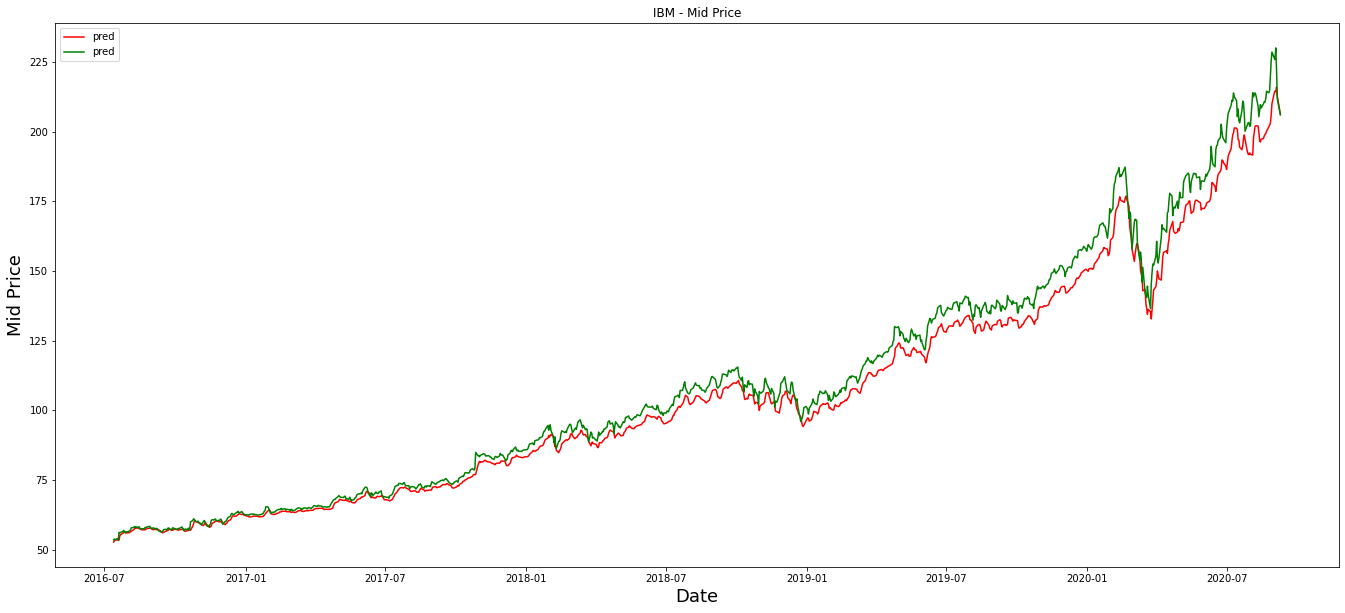

In [456]:
model = run_model(X_train, y_train, X_test, y_test, dates, symbol, train_size, bidirectional=False, plot=True)

We observe that the model works better without the bidirectional feature.

### Save model

When the model will be ok, we can save all the models for the Flask application.

In [401]:
symbol = "IBM"
model_ibm.save(f'model_{symbol}.p')

INFO:tensorflow:Assets written to: model_IBM.p/assets


## Should we buy or sell ?

We buy when we predict the price is going up tomorrow.
We sell when we predict the price is going down tomorrow.

We add a tolerance of 0.05cts.

In [396]:
def predict(model, prices, window=3):
    window_values = prices[len(prices) - window:len(prices)].values.reshape(1, window, 1)
    prediction = model.predict(window_values)
    
    if prediction > prices[len(prices) - 1] + 0.05:
        return "You should buy some shares, it is going up tomorrow"
    elif prediction < prices[len(prices) - 1] + 0.05:
        return "You should sell, it is going down tomorrow"
    else:
        return "You should do nothing, it is not moving much"

In [397]:
avg_prices, dates = get_avg_prices("IBM", df_timeseries)
predict(model_ibm, avg_prices)

'You should buy some shares, it is going up tomorrow'

## Export models

In [436]:
symbols = df_timeseries["symbol"].unique()
symbols[2:]

array(['V', 'JPM', 'JNJ', 'WMT', 'PG', 'INTC', 'UNH', 'AMGN', 'HD', 'DIS',
       'KO', 'VZ', 'MRK', 'PFE', 'CVX', 'CSCO', 'BA', 'MCD', 'NKE', 'IBM',
       'AXP', 'MMM', 'GS', 'CAT', 'WBA', 'DD', 'TRV', 'CRM'], dtype=object)

In [457]:
def export_models(symbols, df):
    for symbol in symbols:
        X_train, y_train, X_test, y_test, dates, train_size = prepare_data(symbol, df, time_steps=3)
        model = run_model(X_train, y_train, X_test, y_test, dates, symbol, train_size, bidirectional=False, plot=True)
        model.save(f'model_{symbol}.p')

Epoch 1/30
142/142 [==============================] - 1s 7ms/step - loss: 284.8757 - val_loss: 14.9775
Epoch 2/30
142/142 [==============================] - 1s 5ms/step - loss: 35.9982 - val_loss: 9.0960
Epoch 3/30
142/142 [==============================] - 1s 5ms/step - loss: 36.4538 - val_loss: 4.6161
Epoch 4/30
142/142 [==============================] - 1s 5ms/step - loss: 34.8962 - val_loss: 1.8547
Epoch 5/30
142/142 [==============================] - 1s 6ms/step - loss: 32.9149 - val_loss: 3.2386
Epoch 6/30
142/142 [==============================] - 1s 5ms/step - loss: 35.2163 - val_loss: 9.9906
Epoch 7/30
142/142 [==============================] - 1s 8ms/step - loss: 35.2137 - val_loss: 8.5906
Epoch 8/30
142/142 [==============================] - 1s 5ms/step - loss: 38.8422 - val_loss: 9.8844
Epoch 9/30
142/142 [==============================] - 1s 5ms/step - loss: 44.2843 - val_loss: 52.5404
Epoch 10/30
142/142 [==============================] - 1s 5ms/step - loss: 42.1772 - val

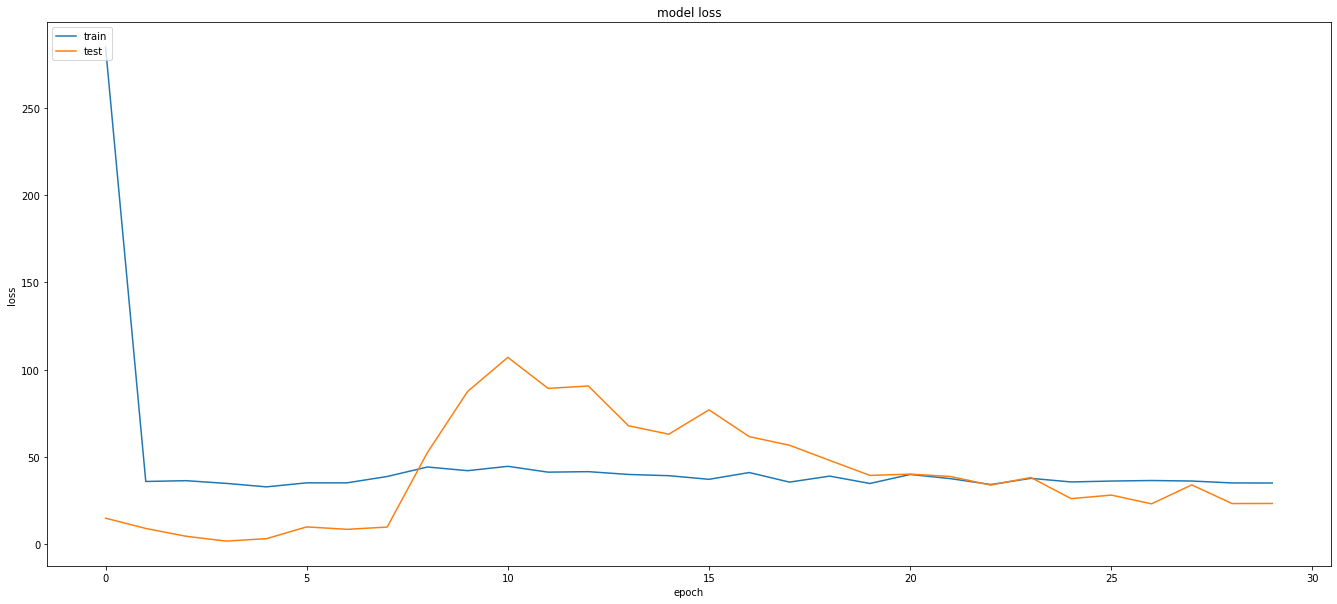

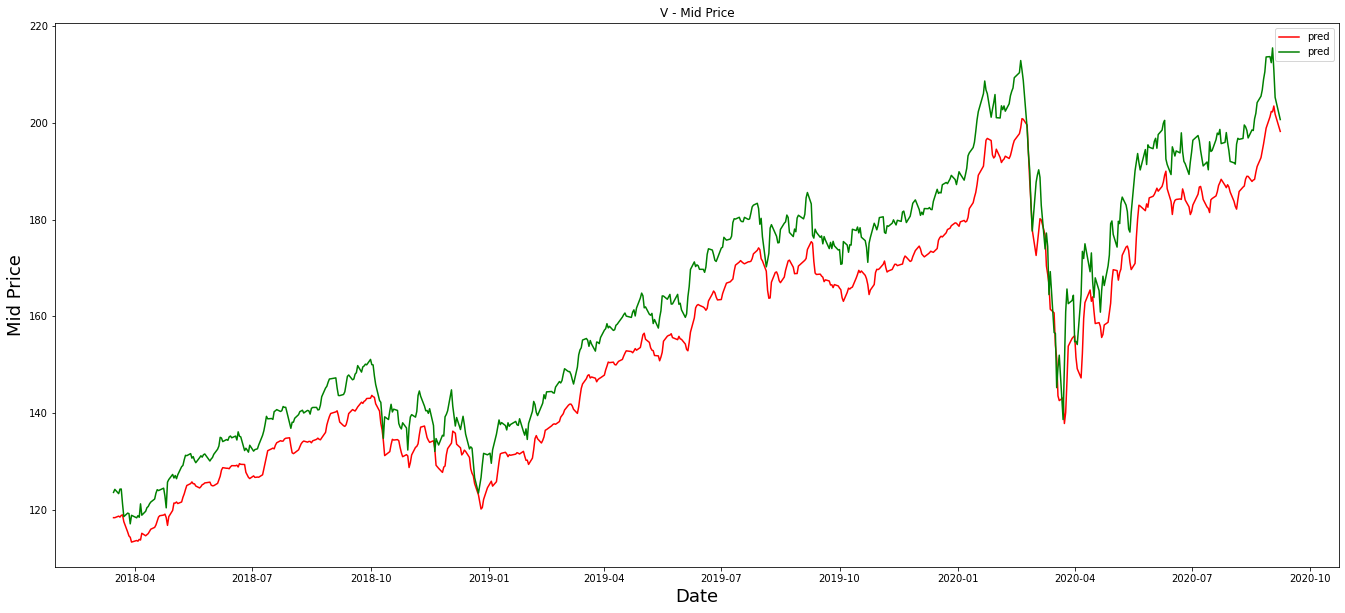

INFO:tensorflow:Assets written to: model_V.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 212.1056 - val_loss: 1.2511
Epoch 2/30
236/236 [==============================] - 1s 6ms/step - loss: 1.6161 - val_loss: 1.1873
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 1.7726 - val_loss: 1.1908
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 1.7945 - val_loss: 1.2406
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 1.8563 - val_loss: 1.3711
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 1.8969 - val_loss: 1.4725
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 1.9081 - val_loss: 1.5885
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 1.9125 - val_loss: 1.6545
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 1.9077 - val_loss: 1.6329
Epoch 10/30
236/236 [=========================

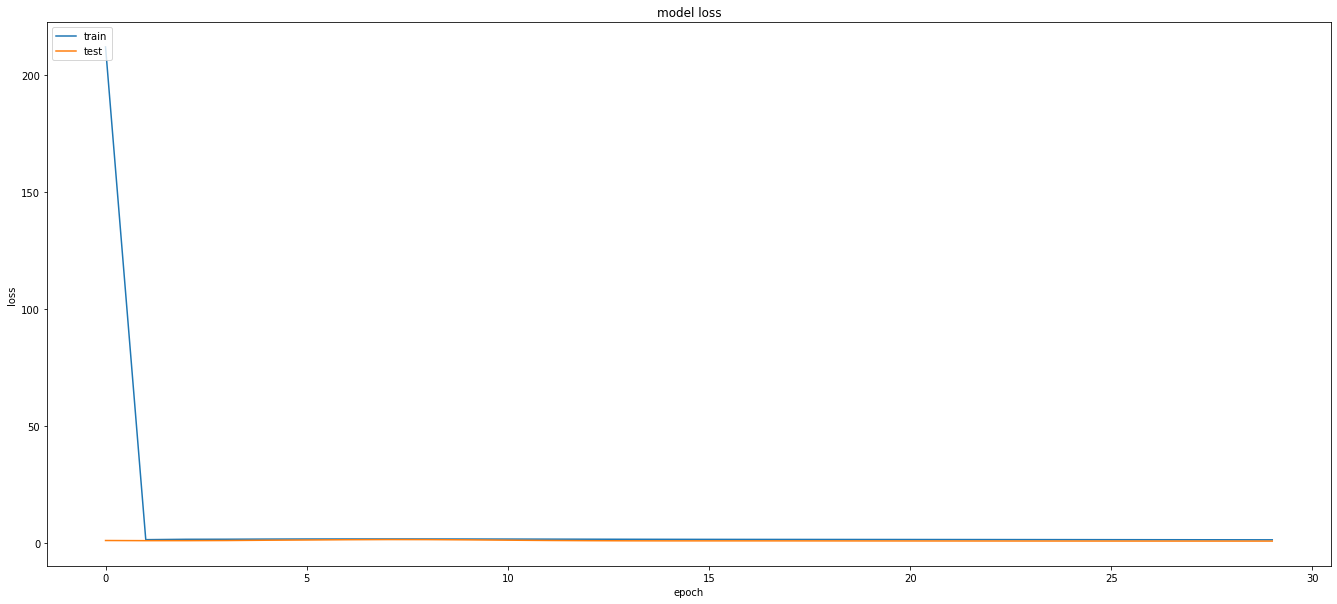

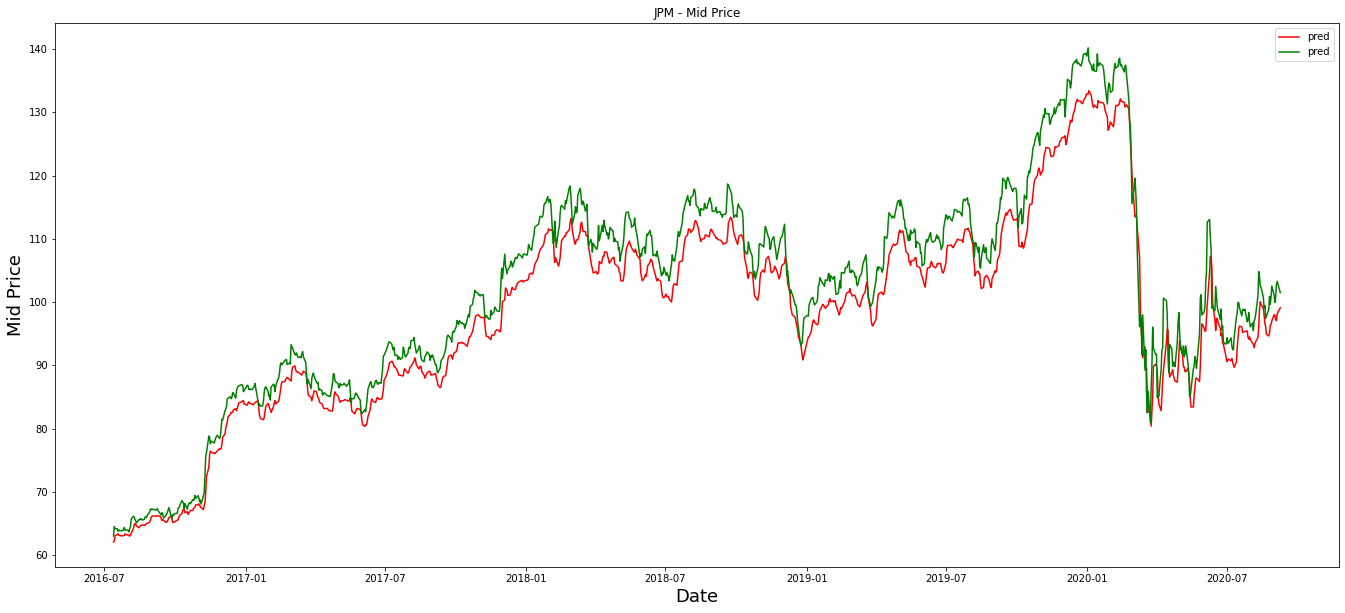

INFO:tensorflow:Assets written to: model_JPM.p/assets
Epoch 1/30
236/236 [==============================] - 2s 6ms/step - loss: 237.3203 - val_loss: 1.4339
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 2.2097 - val_loss: 1.4363
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 2.2303 - val_loss: 1.4335
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 2.3374 - val_loss: 1.3662
Epoch 5/30
236/236 [==============================] - 1s 6ms/step - loss: 2.4024 - val_loss: 1.3170
Epoch 6/30
236/236 [==============================] - 1s 6ms/step - loss: 2.7201 - val_loss: 1.3196
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 2.9263 - val_loss: 1.3894
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 3.2643 - val_loss: 1.4033
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 3.4267 - val_loss: 1.3936
Epoch 10/30
236/236 [=======================

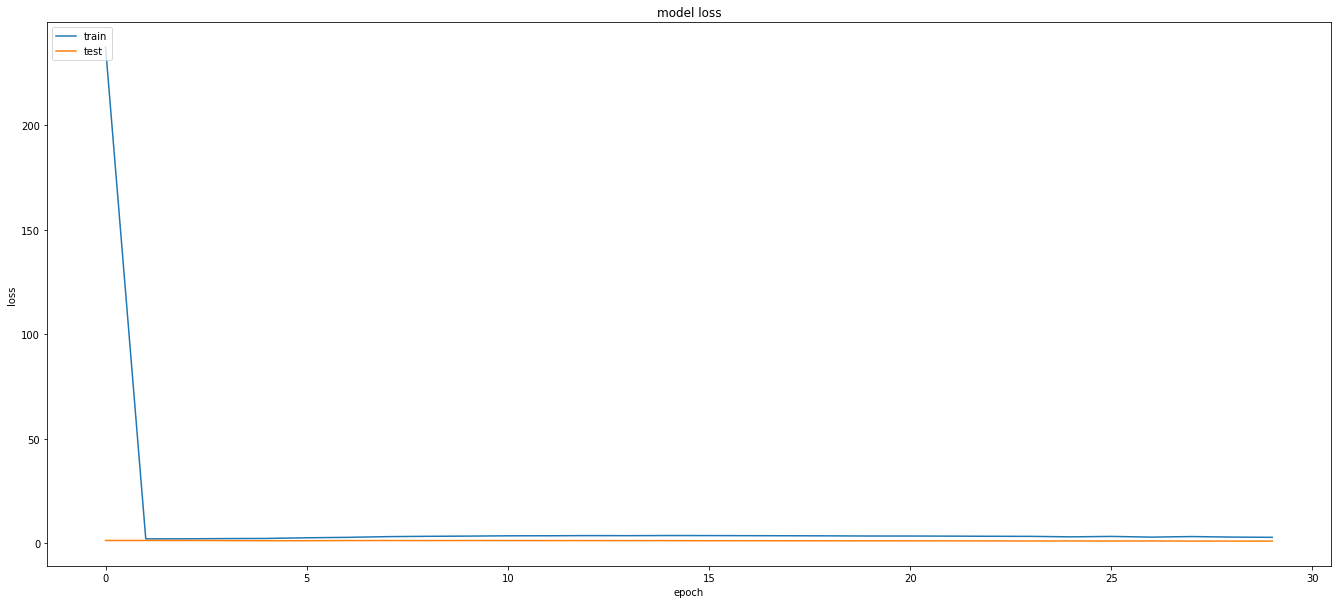

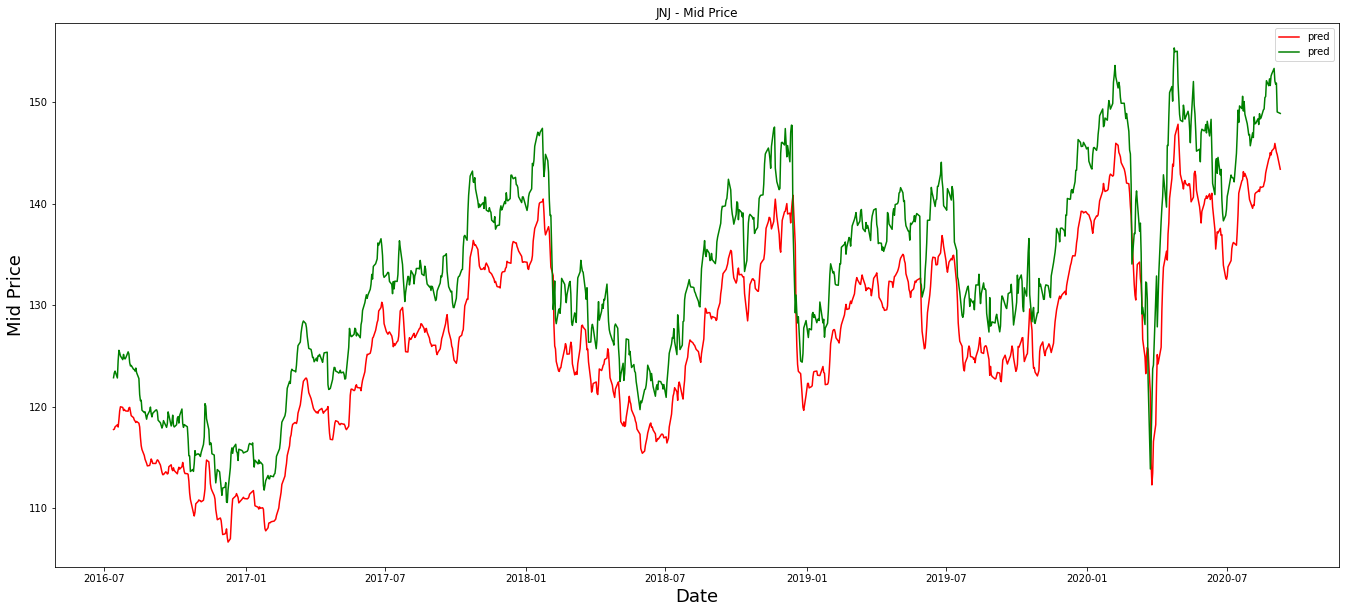

INFO:tensorflow:Assets written to: model_JNJ.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 115.3110 - val_loss: 1.2577
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 1.1065 - val_loss: 1.1281
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9859 - val_loss: 1.1348
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9368 - val_loss: 2.1996
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 1.0703 - val_loss: 3.4197
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 1.2174 - val_loss: 4.2997
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 1.3358 - val_loss: 3.8913
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 1.4276 - val_loss: 3.6355
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 1.5181 - val_loss: 2.9523
Epoch 10/30
236/236 [=======================

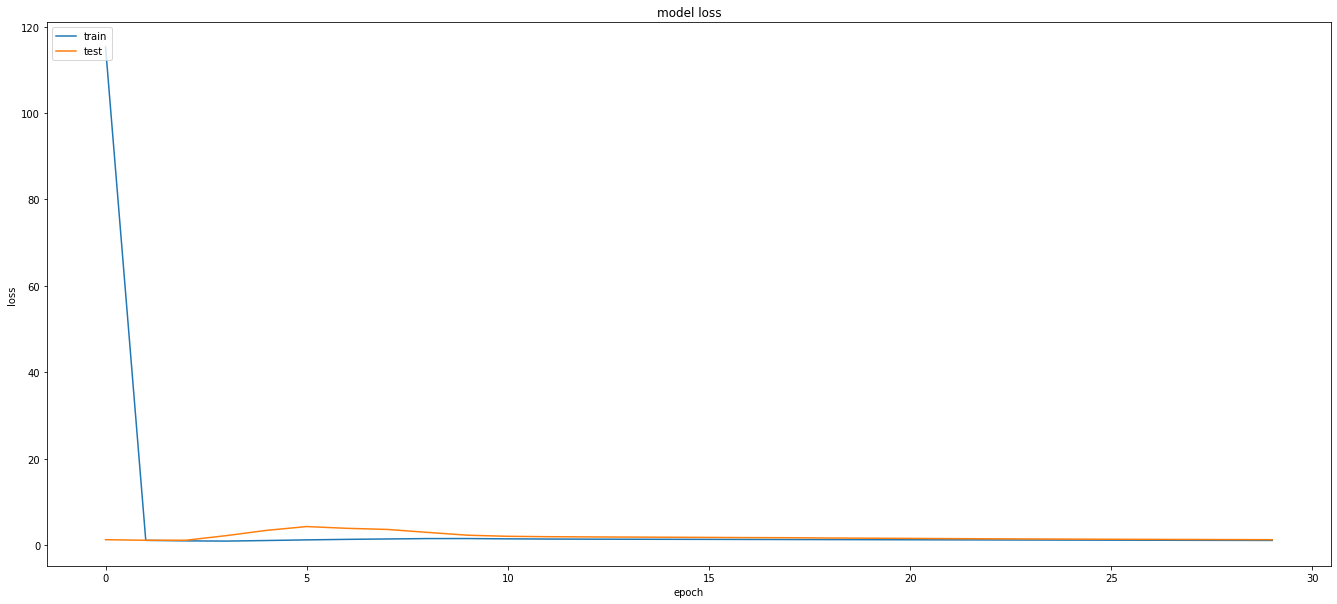

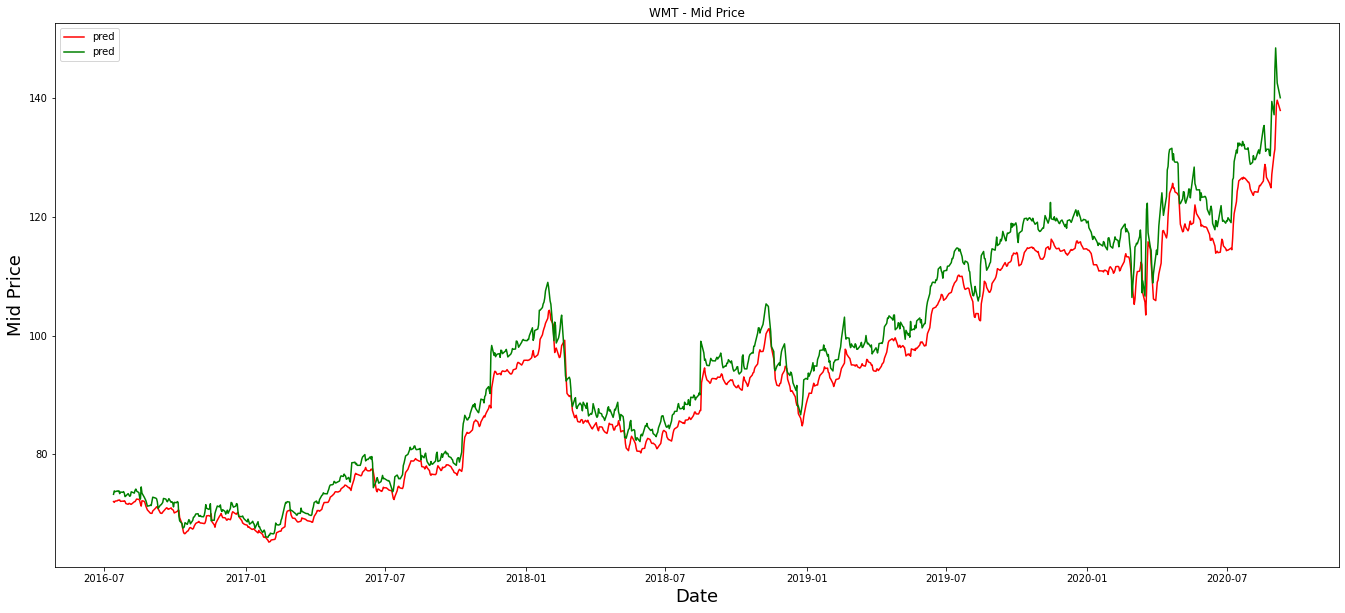

INFO:tensorflow:Assets written to: model_WMT.p/assets
Epoch 1/30
236/236 [==============================] - 2s 6ms/step - loss: 315.8570 - val_loss: 0.8983
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 3.2705 - val_loss: 0.8145
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 2.8860 - val_loss: 0.8745
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 3.0676 - val_loss: 1.0996
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 3.8146 - val_loss: 1.2107
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 4.2070 - val_loss: 1.2729
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 4.4549 - val_loss: 1.3589
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 4.7020 - val_loss: 1.4430
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 4.8908 - val_loss: 1.5465
Epoch 10/30
236/236 [=======================

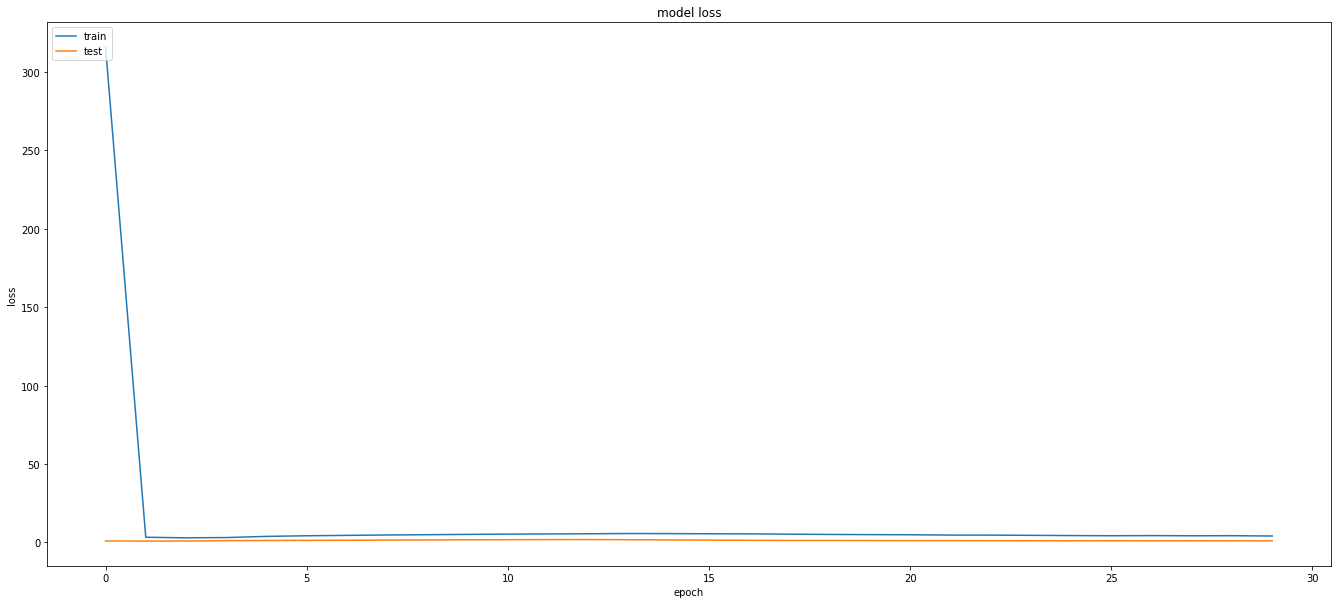

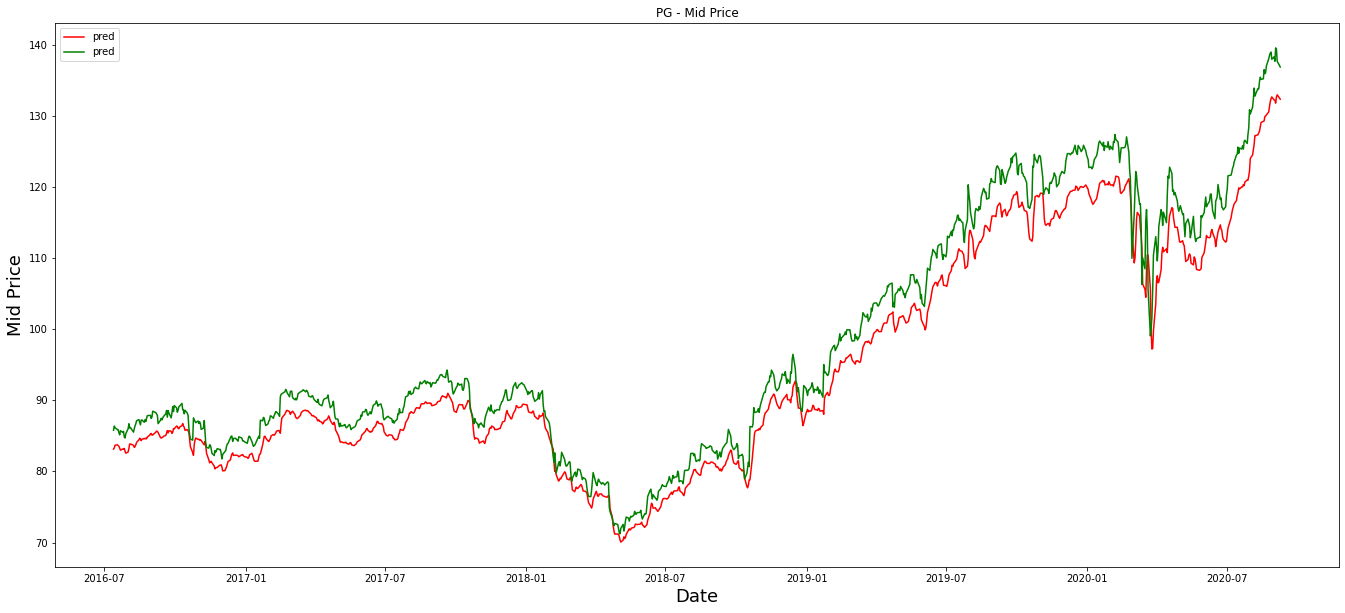

INFO:tensorflow:Assets written to: model_PG.p/assets
Epoch 1/30
236/236 [==============================] - 2s 6ms/step - loss: 367.0429 - val_loss: 2.3232
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 11.8471 - val_loss: 2.1817
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 9.1933 - val_loss: 0.8971
Epoch 4/30
236/236 [==============================] - 1s 6ms/step - loss: 8.4195 - val_loss: 0.7210
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 8.5064 - val_loss: 0.7956
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 9.1477 - val_loss: 0.9295
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 10.3567 - val_loss: 1.0532
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 11.5753 - val_loss: 1.1180
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 11.5742 - val_loss: 1.2440
Epoch 10/30
236/236 [====================

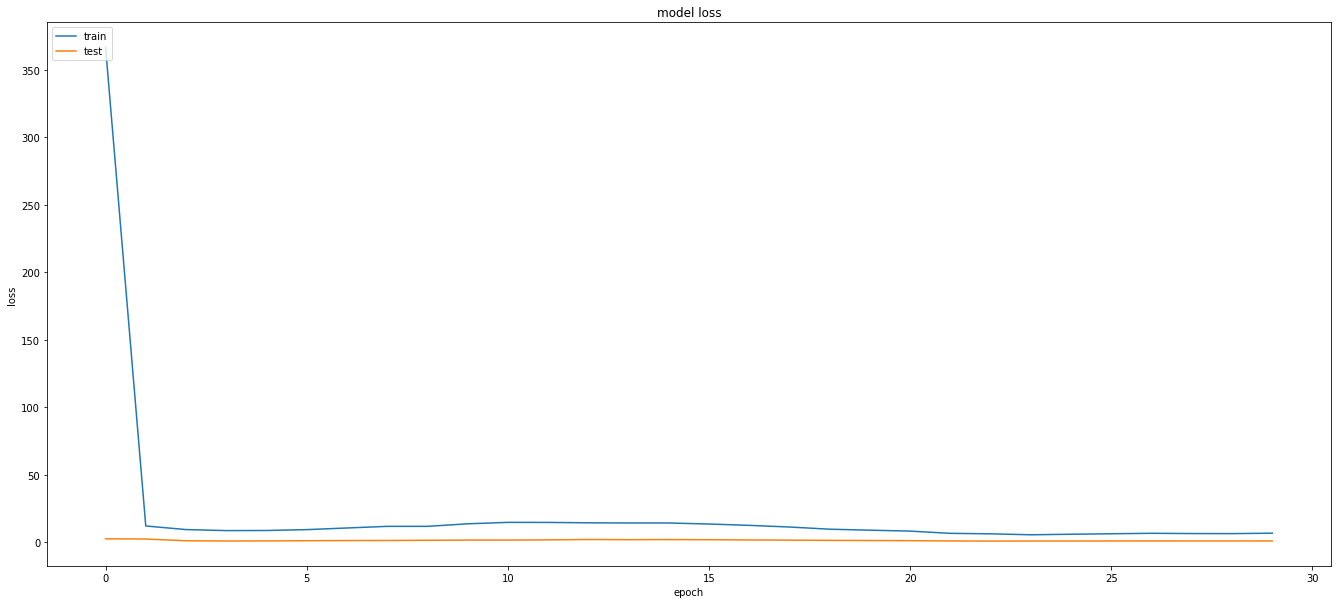

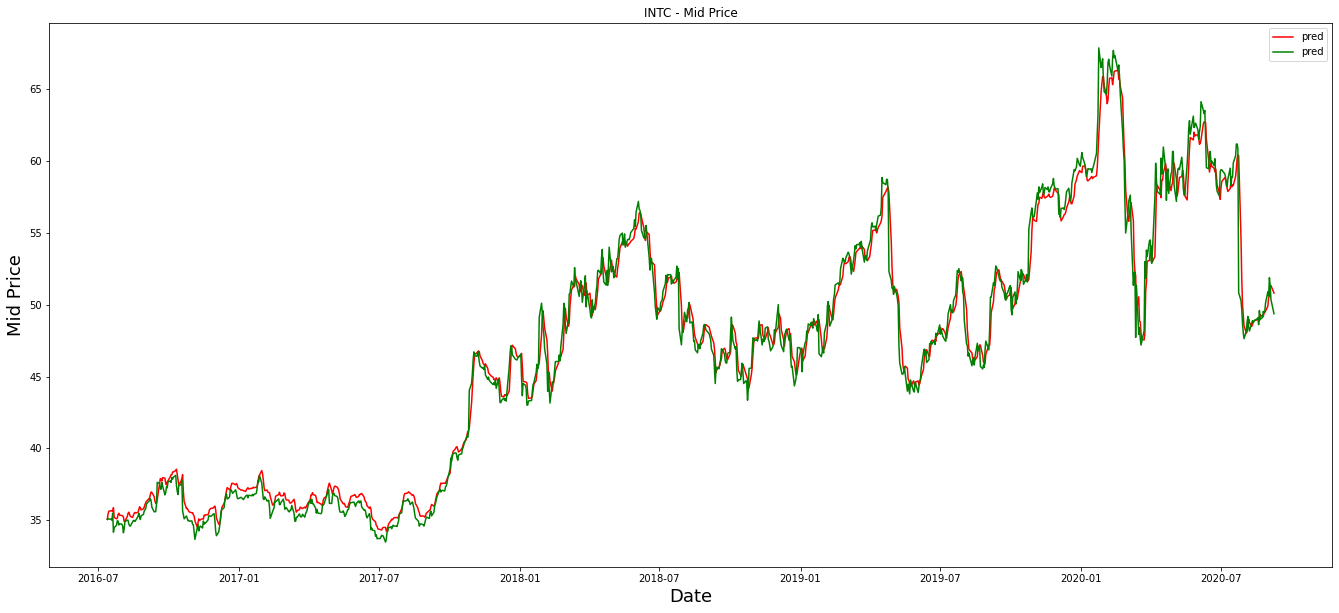

INFO:tensorflow:Assets written to: model_INTC.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 142.8549 - val_loss: 3.4251
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 5.0004 - val_loss: 3.6171
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 5.0820 - val_loss: 4.9670
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 5.9424 - val_loss: 7.8060
Epoch 5/30
236/236 [==============================] - 2s 7ms/step - loss: 6.7508 - val_loss: 8.4760
Epoch 6/30
236/236 [==============================] - 2s 7ms/step - loss: 7.2205 - val_loss: 9.2354
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 7.2334 - val_loss: 8.8707
Epoch 8/30
236/236 [==============================] - 2s 8ms/step - loss: 7.0847 - val_loss: 9.5345
Epoch 9/30
236/236 [==============================] - 2s 7ms/step - loss: 7.0409 - val_loss: 10.0452
Epoch 10/30
236/236 [=====================

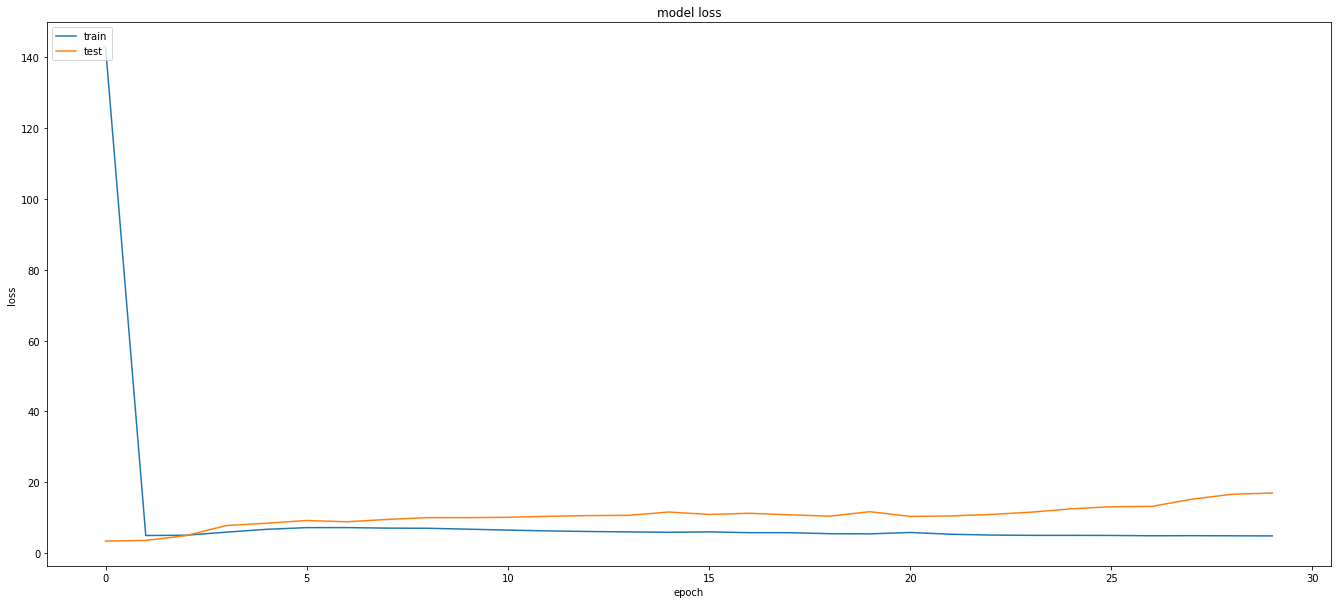

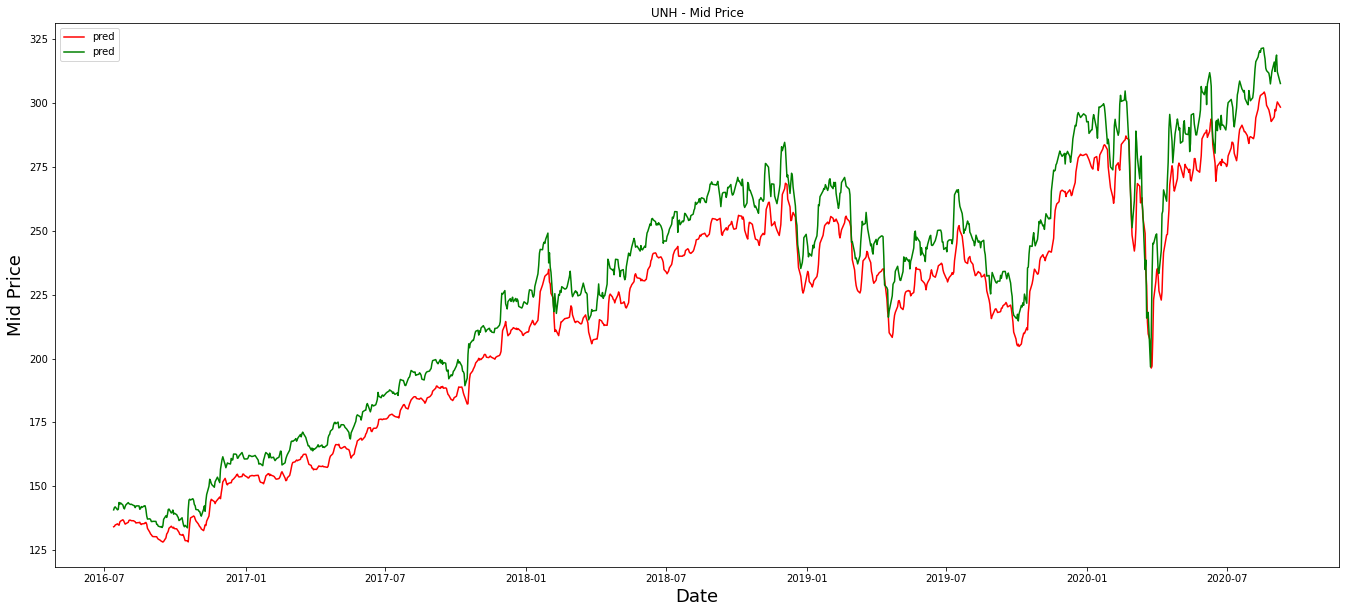

INFO:tensorflow:Assets written to: model_UNH.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 174.6846 - val_loss: 10.7097
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 3.3403 - val_loss: 7.5026
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 3.2789 - val_loss: 7.1661
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 3.3873 - val_loss: 7.2078
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 3.3909 - val_loss: 7.2354
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 3.4201 - val_loss: 7.1601
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 3.4317 - val_loss: 7.1121
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 3.4209 - val_loss: 7.0654
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 3.3843 - val_loss: 7.0219
Epoch 10/30
236/236 [======================

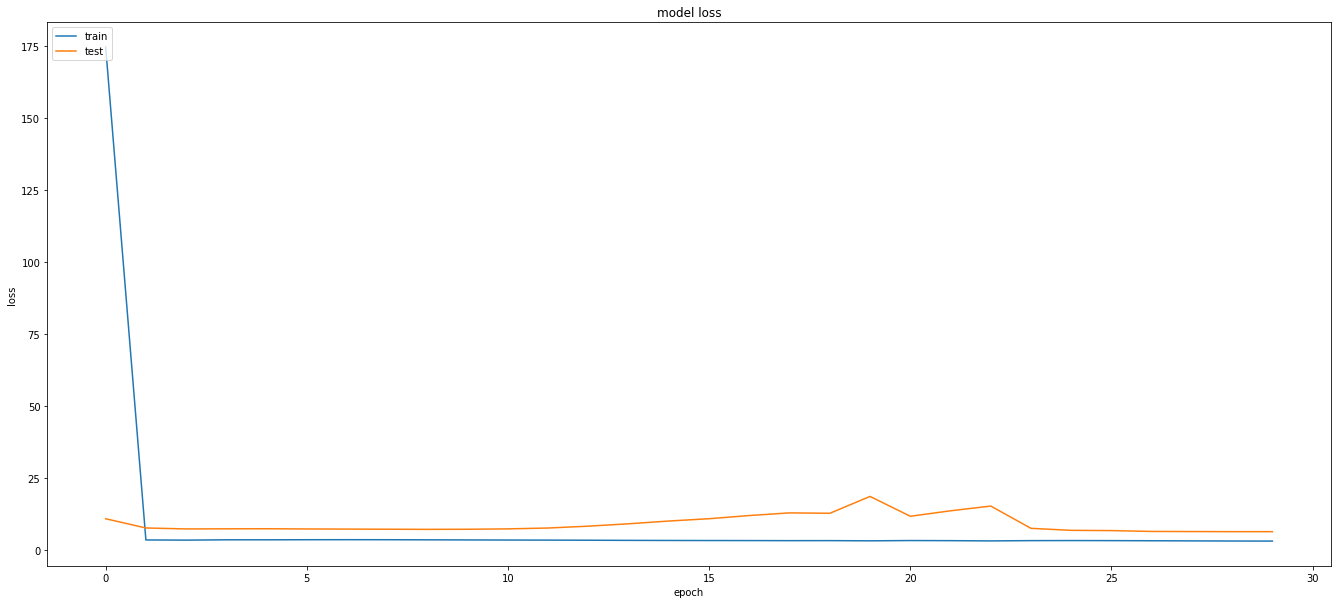

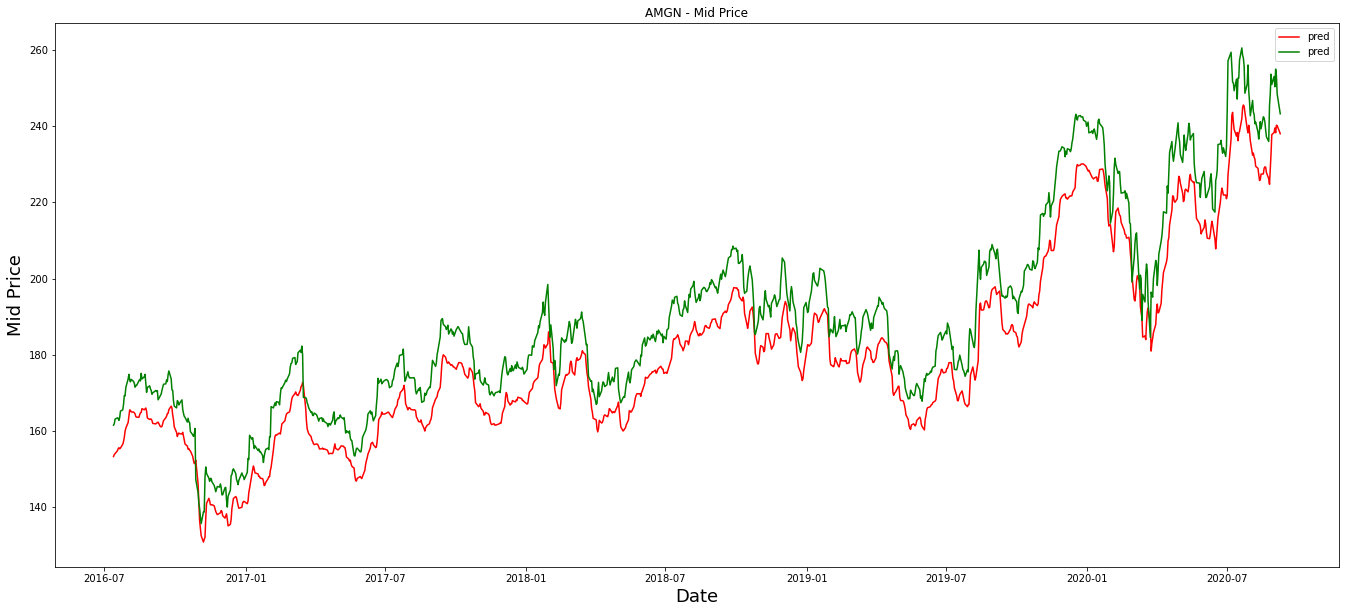

INFO:tensorflow:Assets written to: model_AMGN.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 218.9358 - val_loss: 3.3240
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 2.2233 - val_loss: 3.4703
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 1.8493 - val_loss: 5.1404
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 1.6300 - val_loss: 5.0190
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 1.8577 - val_loss: 5.2307
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 1.9808 - val_loss: 5.0055
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 2.0998 - val_loss: 4.7583
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 2.1915 - val_loss: 4.5098
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 2.2497 - val_loss: 4.3557
Epoch 10/30
236/236 [======================

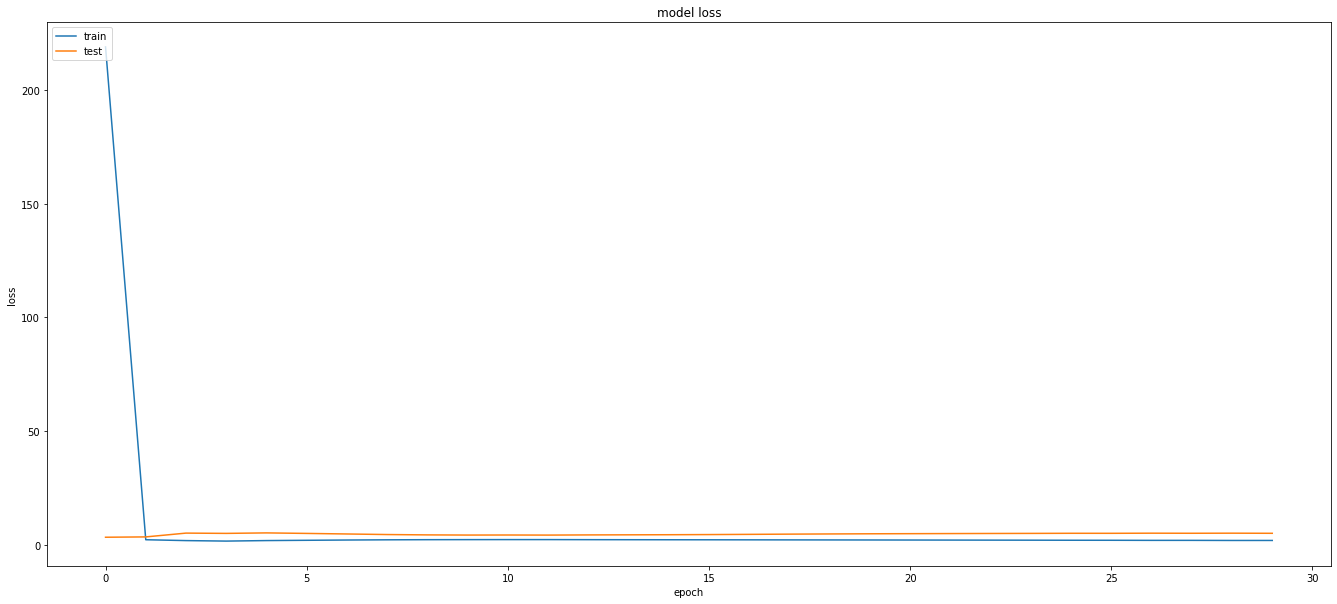

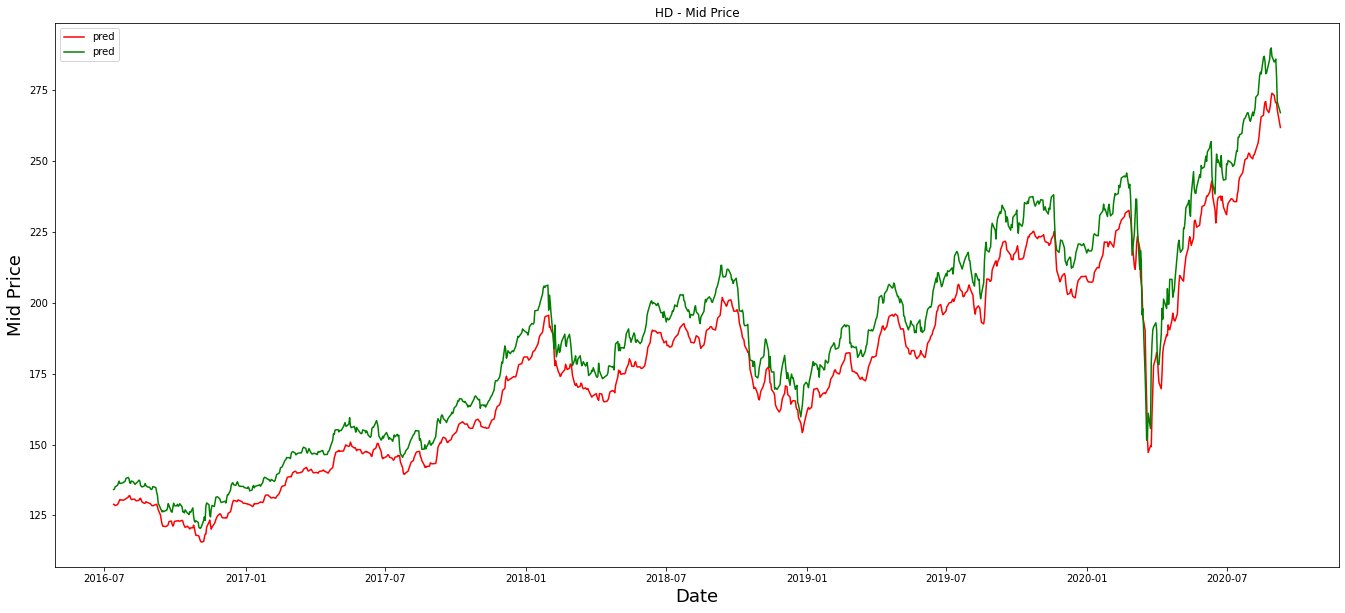

INFO:tensorflow:Assets written to: model_HD.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 45.6256 - val_loss: 3.1363
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 1.2409 - val_loss: 3.1965
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9275 - val_loss: 3.2791
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 0.8515 - val_loss: 5.1704
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7277 - val_loss: 5.7354
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 0.6074 - val_loss: 4.8411
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 0.5897 - val_loss: 4.4635
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 0.5881 - val_loss: 4.9252
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 0.6015 - val_loss: 5.1626
Epoch 10/30
236/236 [=========================

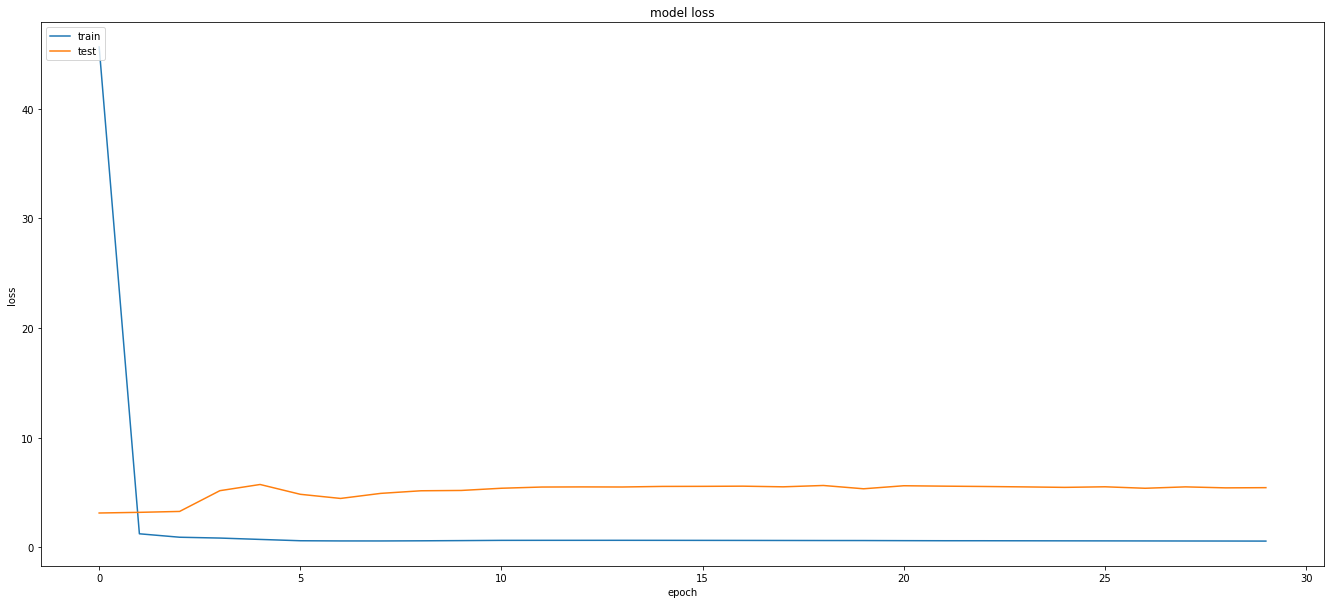

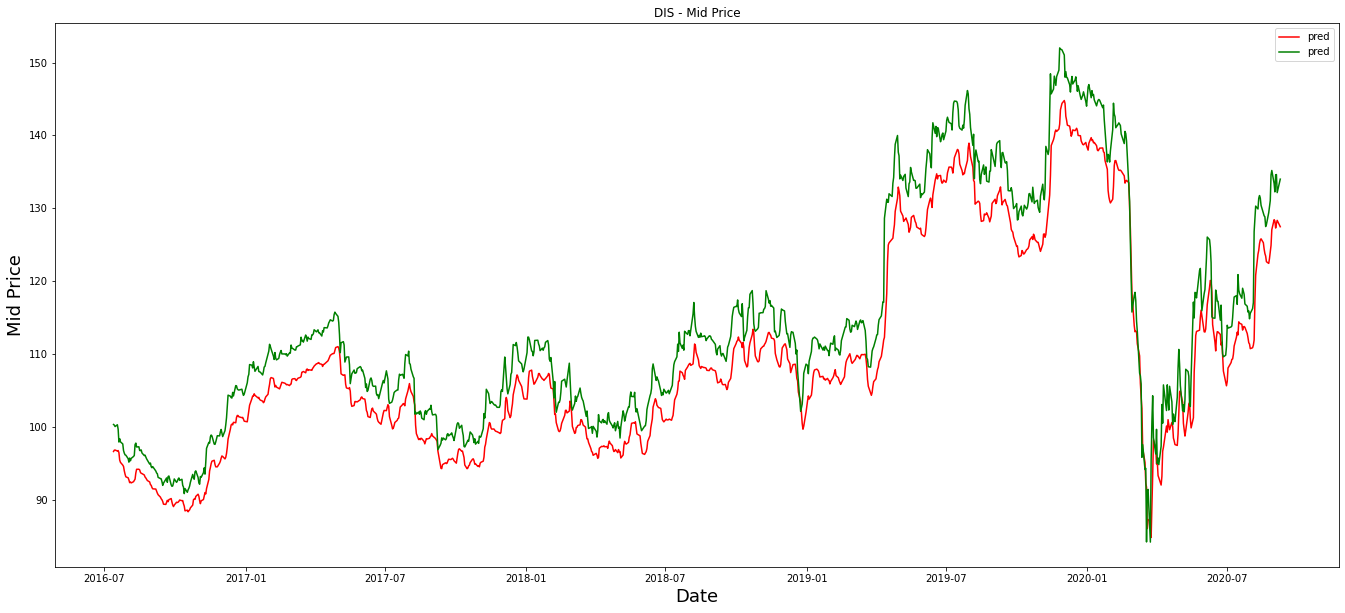

INFO:tensorflow:Assets written to: model_DIS.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 88.1250 - val_loss: 0.3928
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 1.6273 - val_loss: 0.2089
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 1.4914 - val_loss: 0.3745
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 1.7500 - val_loss: 0.2755
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 1.9252 - val_loss: 0.3067
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 2.0359 - val_loss: 0.3284
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 2.1340 - val_loss: 0.3253
Epoch 8/30
236/236 [==============================] - 2s 7ms/step - loss: 2.1400 - val_loss: 0.3154
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 2.1634 - val_loss: 0.3272
Epoch 10/30
236/236 [========================

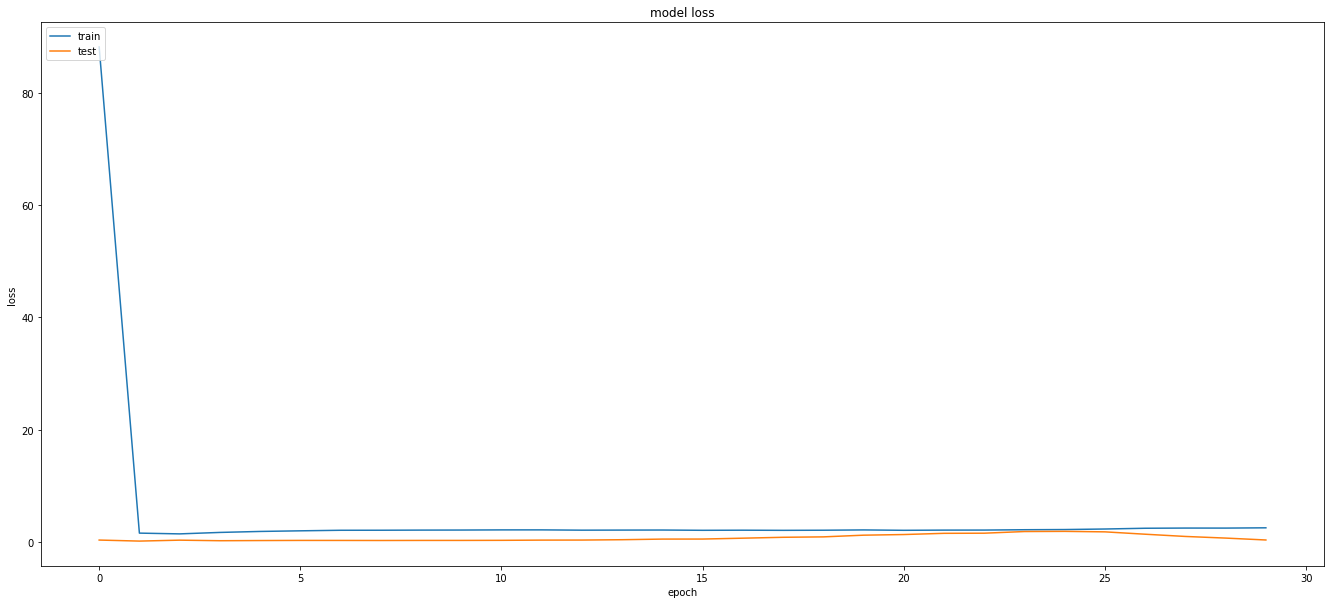

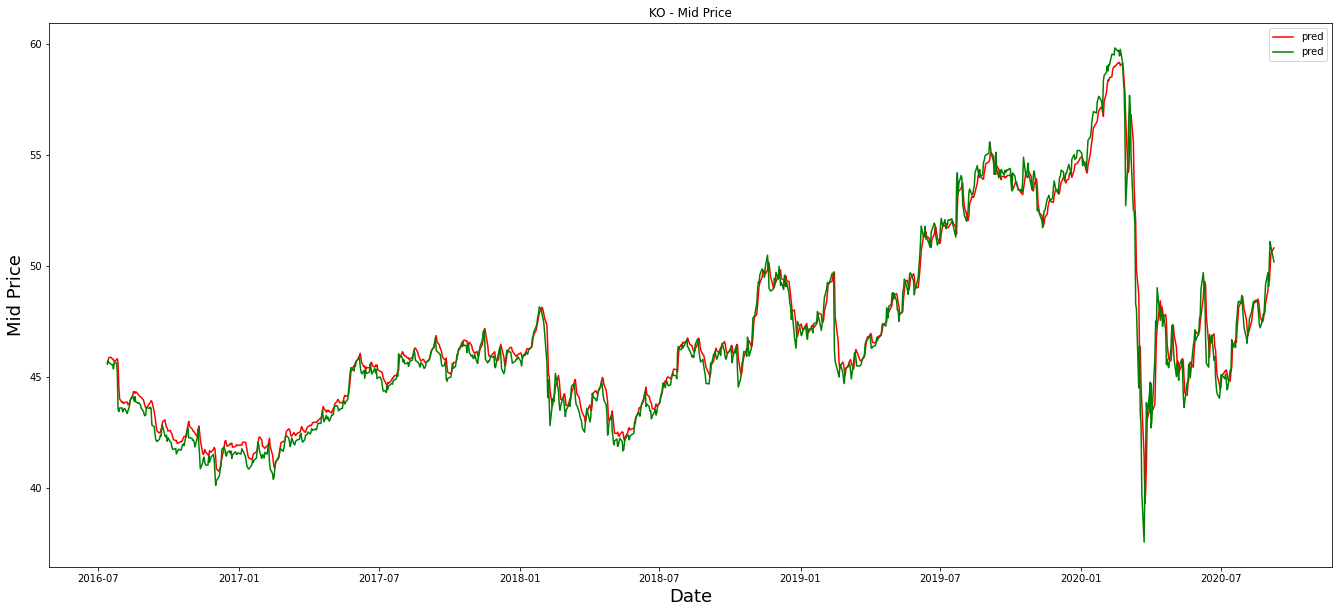

INFO:tensorflow:Assets written to: model_KO.p/assets
Epoch 1/30
236/236 [==============================] - 2s 6ms/step - loss: 131.2445 - val_loss: 0.3894
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7726 - val_loss: 0.4168
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 0.6194 - val_loss: 0.3562
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 0.6203 - val_loss: 0.3737
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 0.6650 - val_loss: 0.4424
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7366 - val_loss: 0.3868
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7841 - val_loss: 0.3570
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7989 - val_loss: 0.3784
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 0.8039 - val_loss: 0.4047
Epoch 10/30
236/236 [========================

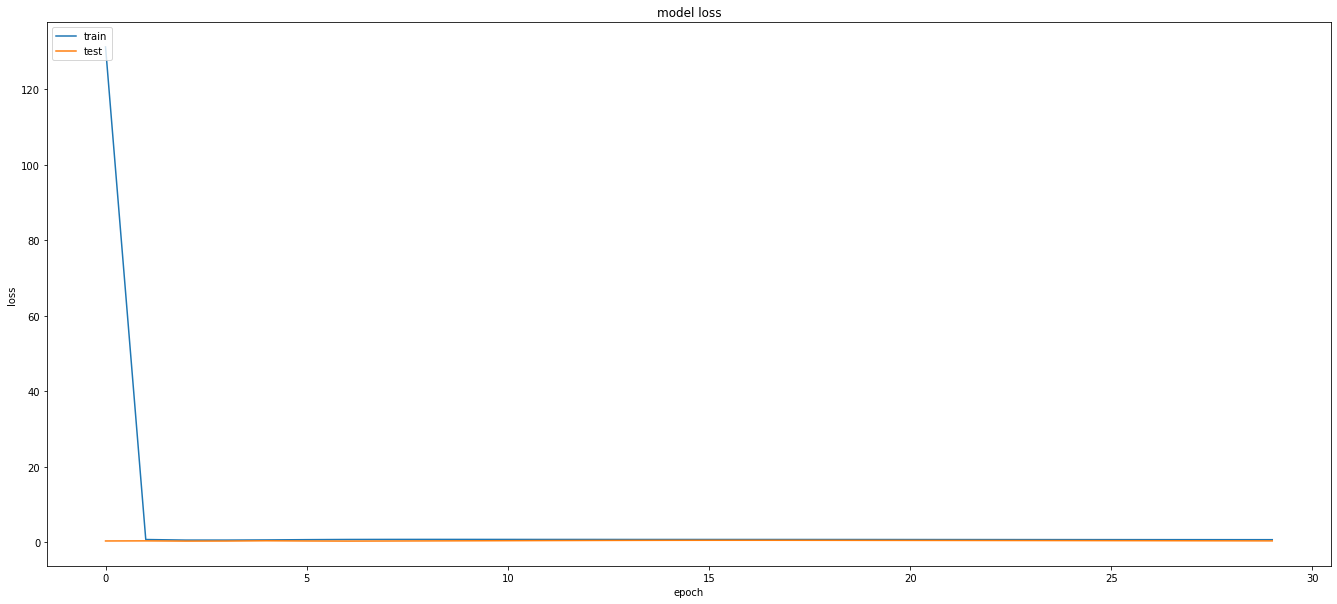

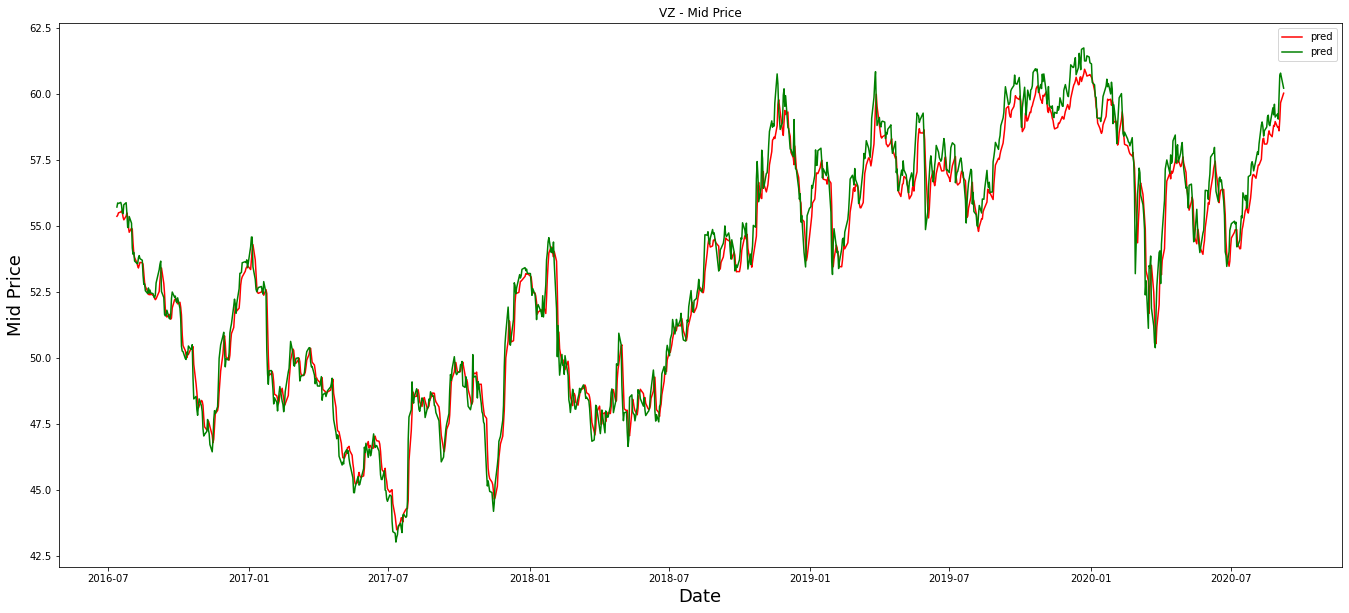

INFO:tensorflow:Assets written to: model_VZ.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 150.6876 - val_loss: 0.7785
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 1.3171 - val_loss: 0.7541
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 1.2261 - val_loss: 0.7875
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 1.3112 - val_loss: 0.7967
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 1.3740 - val_loss: 0.7740
Epoch 6/30
236/236 [==============================] - 1s 6ms/step - loss: 1.4107 - val_loss: 0.7706
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 1.4224 - val_loss: 0.7938
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 1.4211 - val_loss: 0.7872
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 1.4362 - val_loss: 0.7530
Epoch 10/30
236/236 [========================

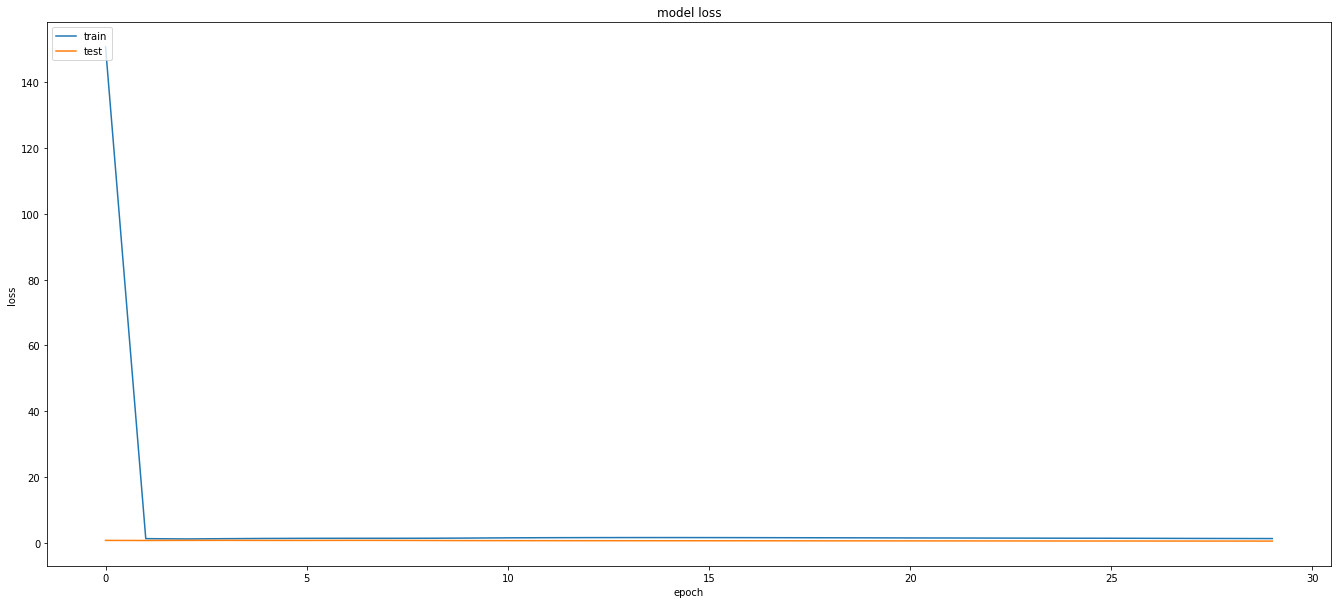

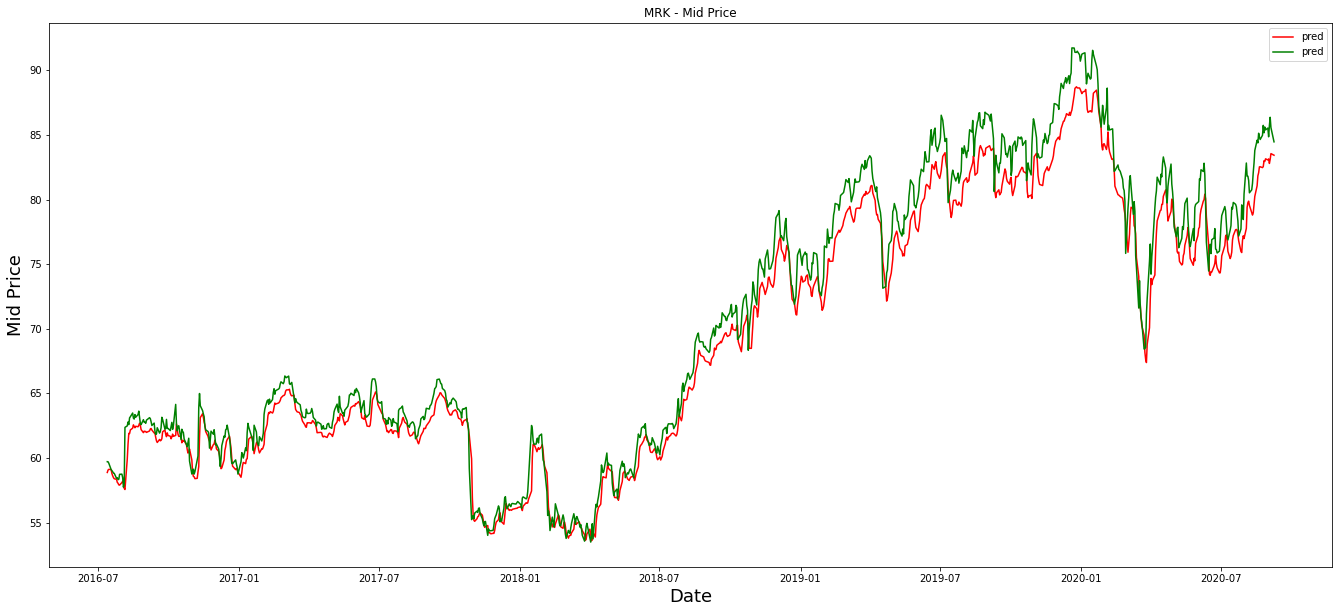

INFO:tensorflow:Assets written to: model_MRK.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 62.4712 - val_loss: 1.1329
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7777 - val_loss: 0.7817
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 0.6518 - val_loss: 0.5347
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 0.5381 - val_loss: 0.3750
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 0.4338 - val_loss: 0.2403
Epoch 6/30
236/236 [==============================] - 2s 7ms/step - loss: 0.3700 - val_loss: 0.2767
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 0.3397 - val_loss: 0.3852
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 0.3517 - val_loss: 0.3994
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 0.3962 - val_loss: 0.3639
Epoch 10/30
236/236 [========================

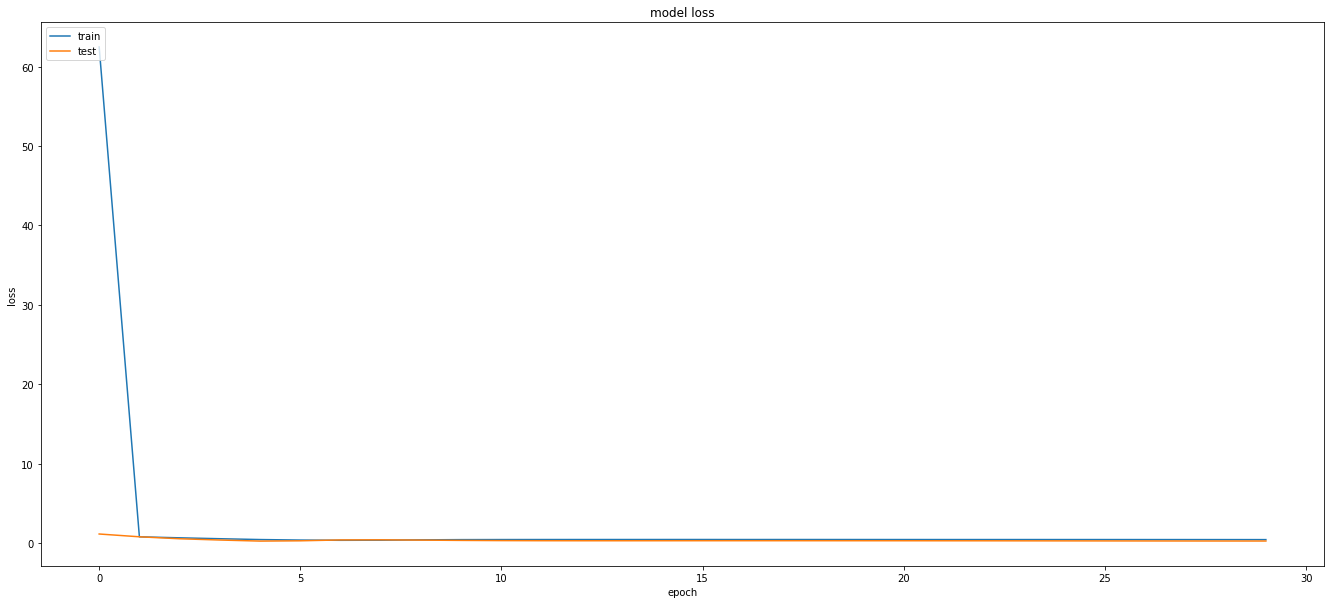

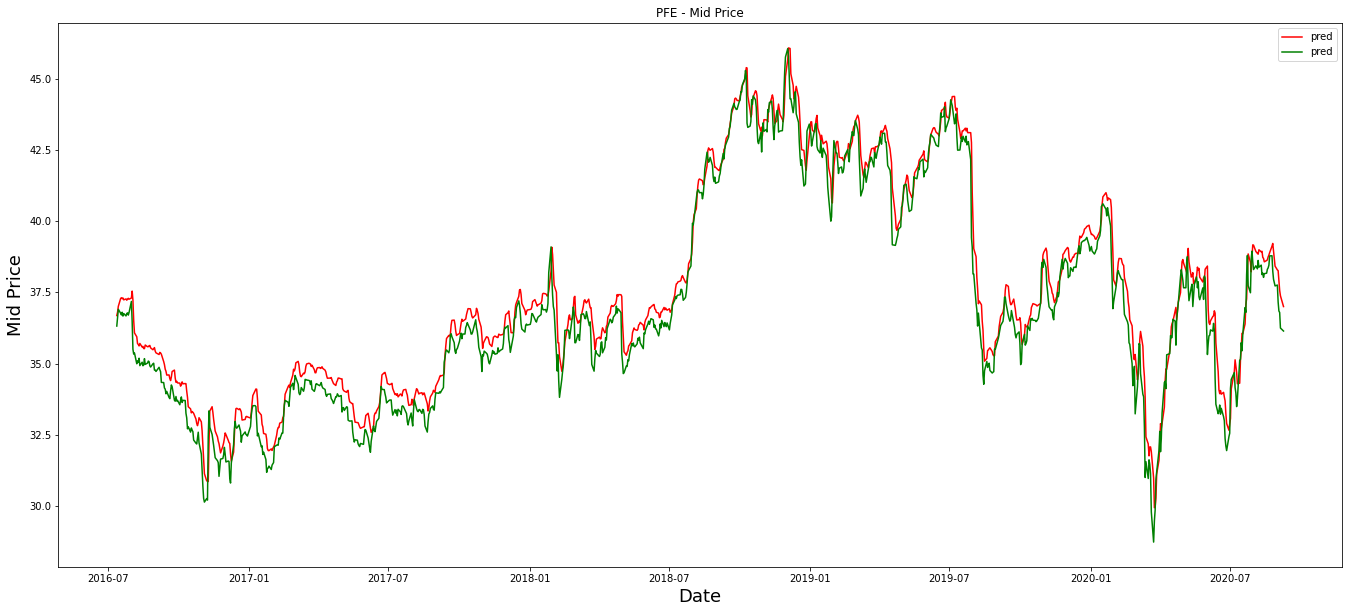

INFO:tensorflow:Assets written to: model_PFE.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 226.4620 - val_loss: 4.9580
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 3.3505 - val_loss: 3.9362
Epoch 3/30
236/236 [==============================] - 1s 6ms/step - loss: 3.2269 - val_loss: 3.9365
Epoch 4/30
236/236 [==============================] - 2s 7ms/step - loss: 3.3686 - val_loss: 3.7667
Epoch 5/30
236/236 [==============================] - 2s 7ms/step - loss: 3.9176 - val_loss: 3.8124
Epoch 6/30
236/236 [==============================] - 2s 8ms/step - loss: 4.1643 - val_loss: 4.1035
Epoch 7/30
236/236 [==============================] - 2s 9ms/step - loss: 4.4462 - val_loss: 4.2159
Epoch 8/30
236/236 [==============================] - 2s 8ms/step - loss: 4.5178 - val_loss: 4.1620
Epoch 9/30
236/236 [==============================] - 2s 7ms/step - loss: 4.5839 - val_loss: 4.2774
Epoch 10/30
236/236 [=======================

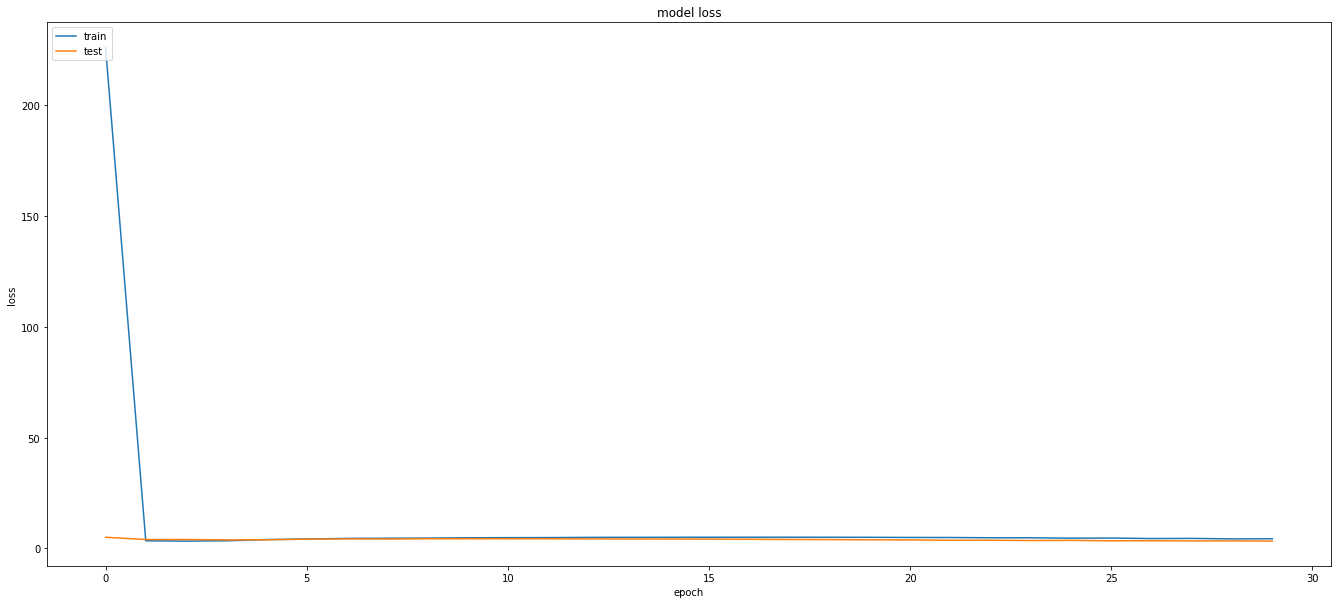

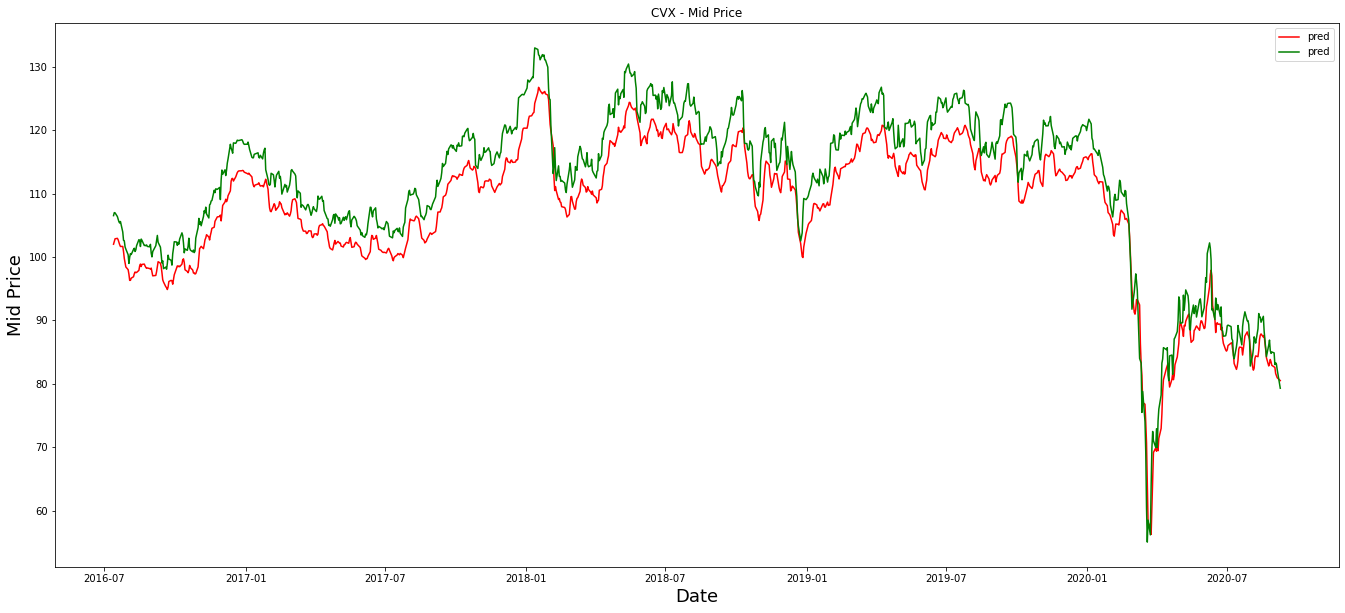

INFO:tensorflow:Assets written to: model_CVX.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 288.6135 - val_loss: 1.4770
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 17.8539 - val_loss: 1.1082
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 11.5736 - val_loss: 0.7445
Epoch 4/30
236/236 [==============================] - 2s 7ms/step - loss: 6.9926 - val_loss: 0.5516
Epoch 5/30
236/236 [==============================] - 2s 9ms/step - loss: 4.7184 - val_loss: 0.4634
Epoch 6/30
236/236 [==============================] - 2s 8ms/step - loss: 3.4365 - val_loss: 0.3765
Epoch 7/30
236/236 [==============================] - 2s 7ms/step - loss: 2.9954 - val_loss: 0.3040
Epoch 8/30
236/236 [==============================] - 2s 7ms/step - loss: 2.7980 - val_loss: 0.2511
Epoch 9/30
236/236 [==============================] - 2s 7ms/step - loss: 2.8058 - val_loss: 0.2296
Epoch 10/30
236/236 [=====================

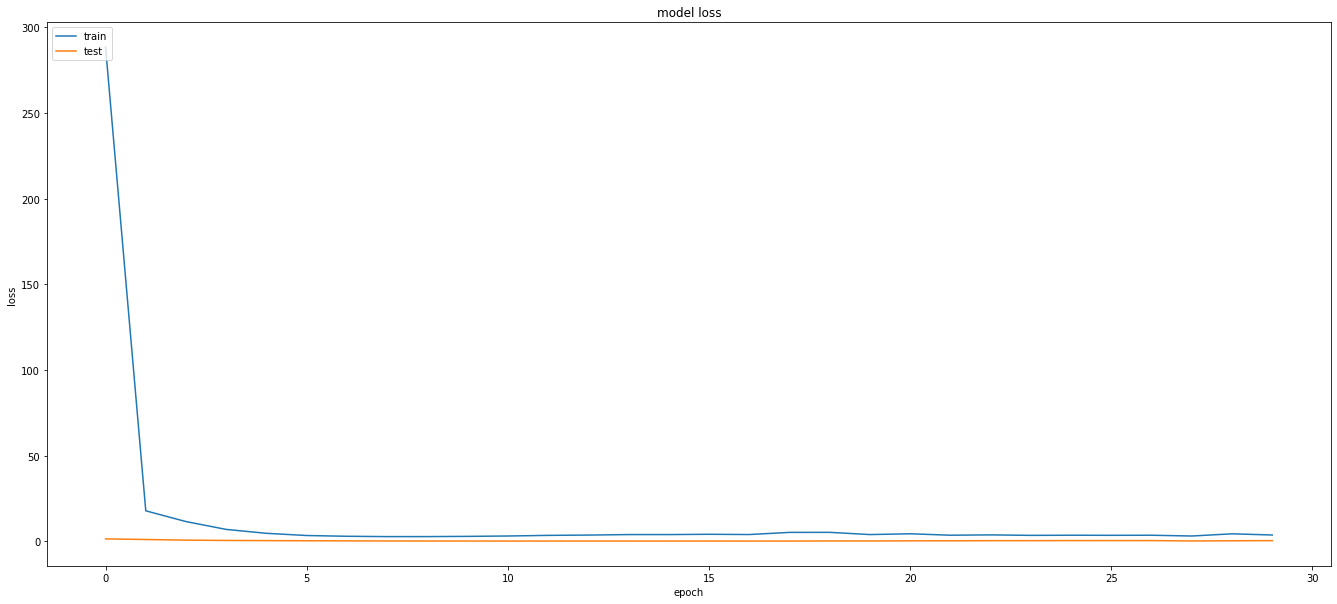

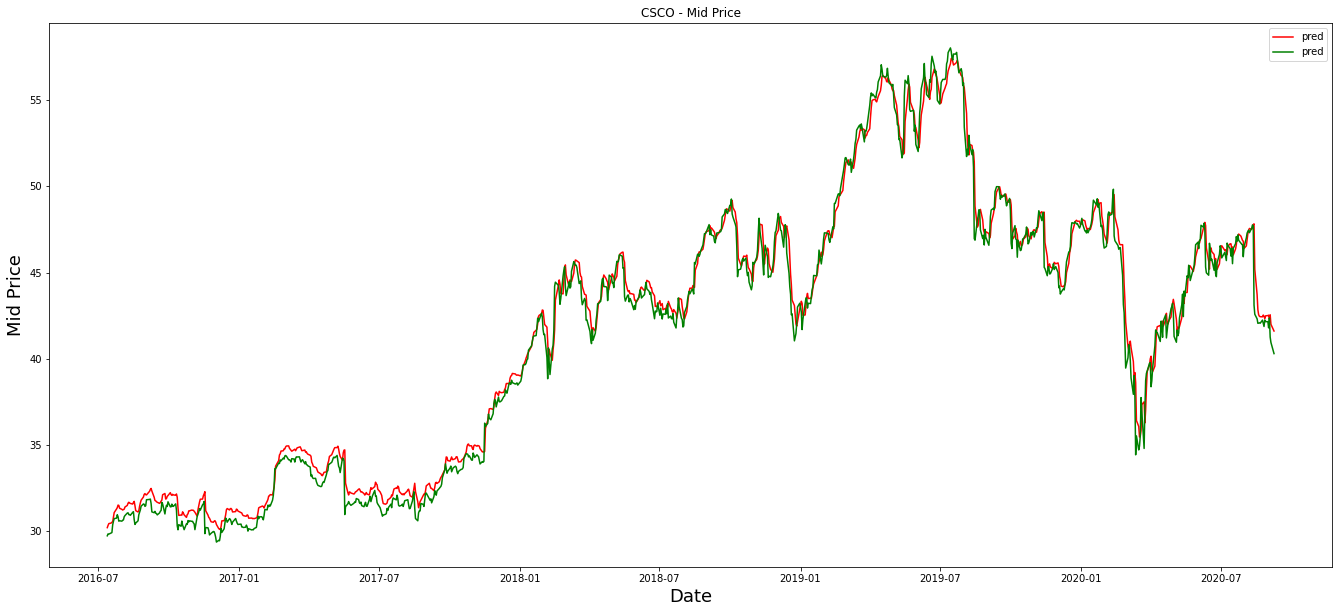

INFO:tensorflow:Assets written to: model_CSCO.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 64.6465 - val_loss: 7.5895
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 2.7667 - val_loss: 12.3821
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 3.5655 - val_loss: 10.4078
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 3.3354 - val_loss: 11.3869
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 2.8945 - val_loss: 12.5641
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 2.8499 - val_loss: 12.9080
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 2.8484 - val_loss: 12.8920
Epoch 8/30
236/236 [==============================] - 2s 7ms/step - loss: 2.8342 - val_loss: 12.8044
Epoch 9/30
236/236 [==============================] - 2s 7ms/step - loss: 2.8054 - val_loss: 12.7263
Epoch 10/30
236/236 [===============

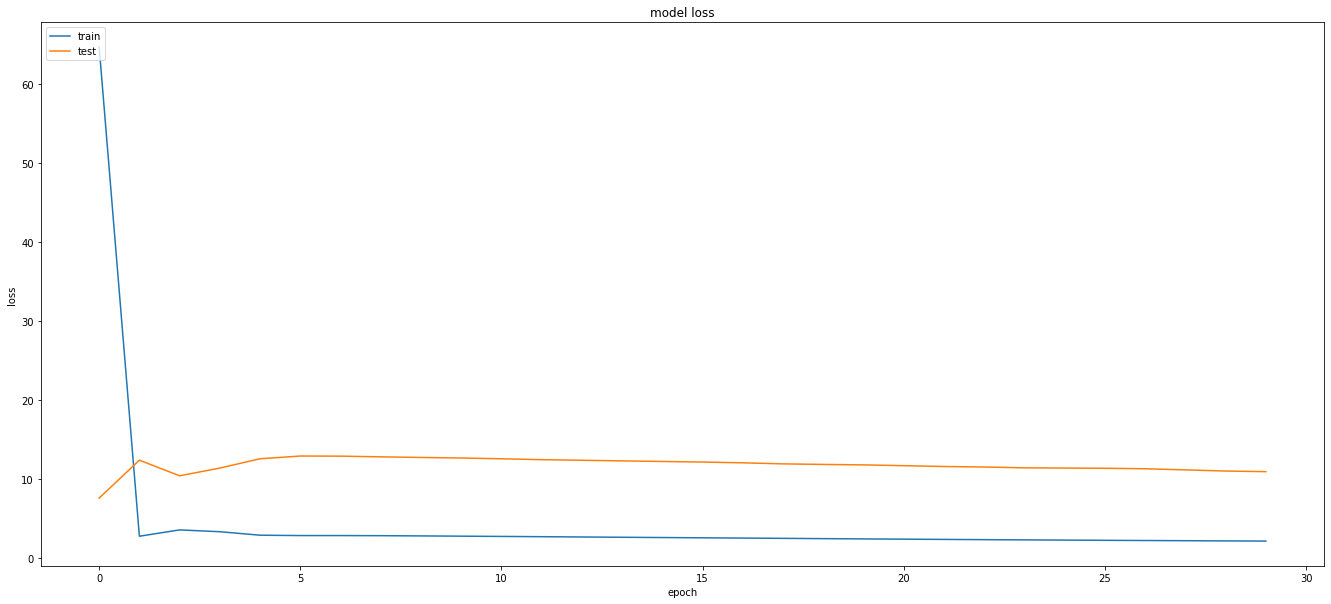

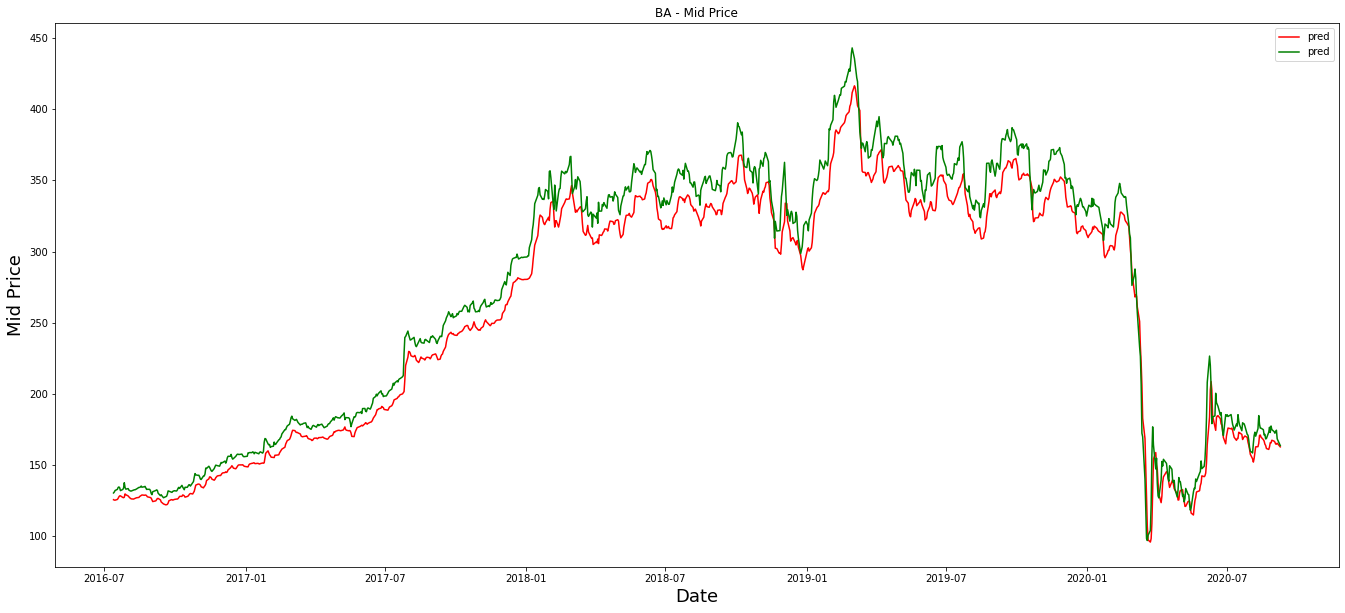

INFO:tensorflow:Assets written to: model_BA.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 55.8955 - val_loss: 1.6671
Epoch 2/30
236/236 [==============================] - 1s 6ms/step - loss: 1.4753 - val_loss: 1.7509
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 1.1925 - val_loss: 1.8571
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 1.0217 - val_loss: 1.9169
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9201 - val_loss: 1.9715
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 0.8732 - val_loss: 2.0020
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 0.8494 - val_loss: 2.0114
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 0.8359 - val_loss: 2.0134
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 0.8260 - val_loss: 2.0001
Epoch 10/30
236/236 [=========================

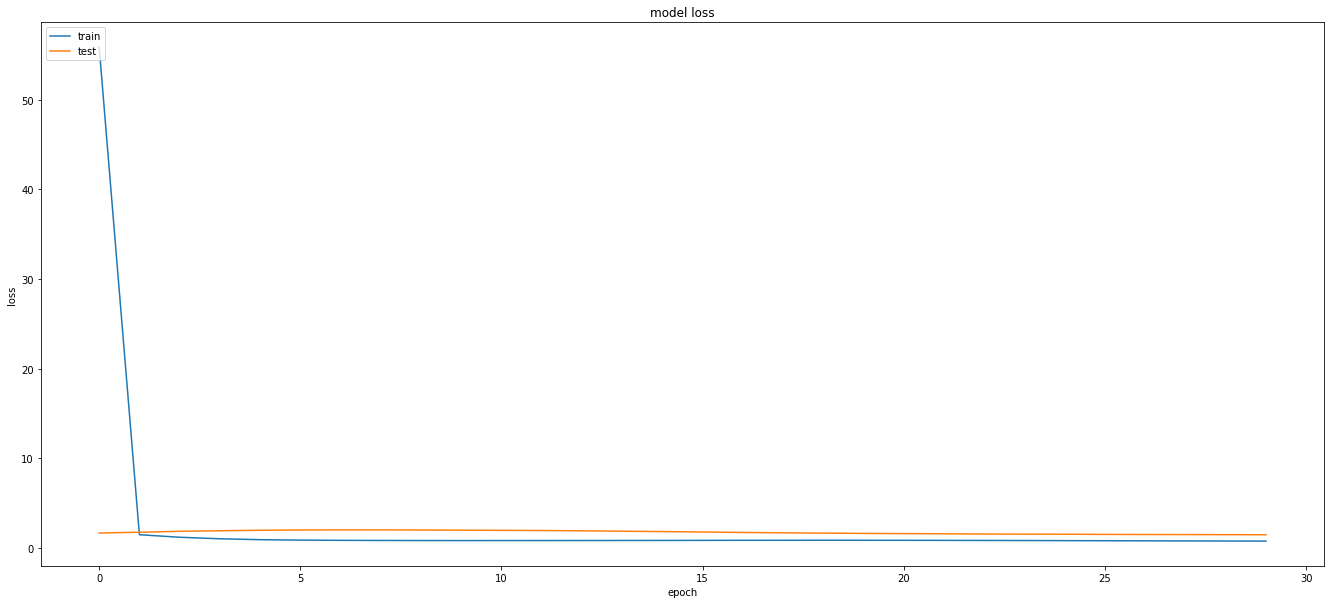

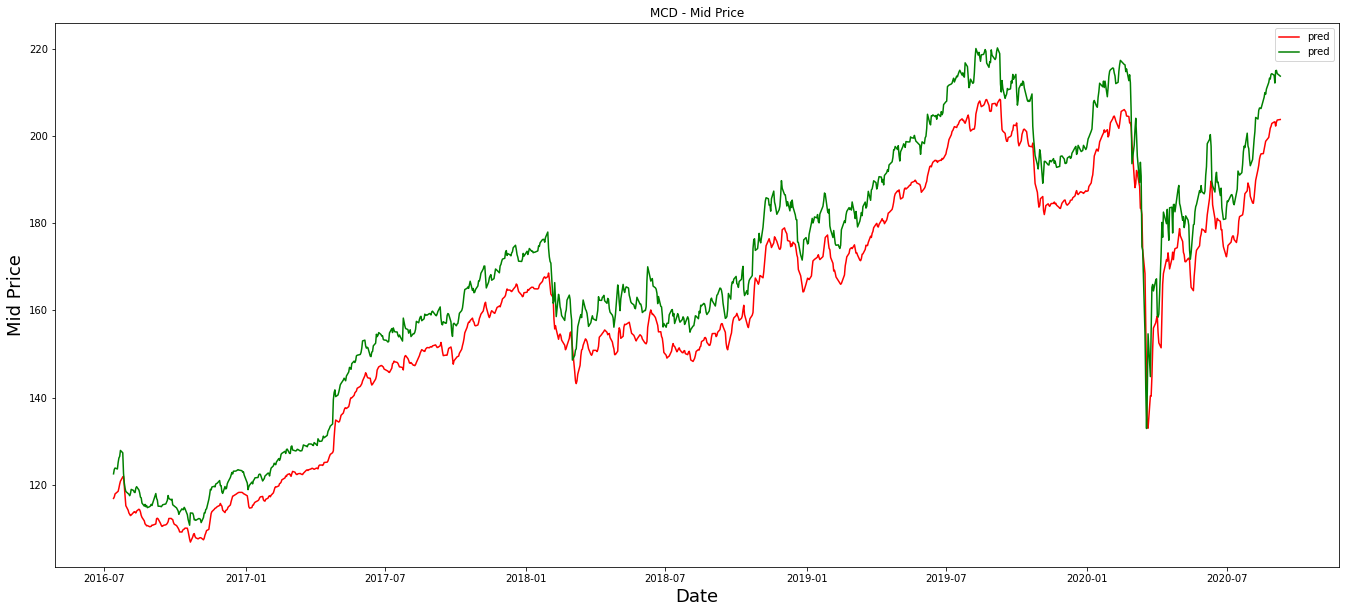

INFO:tensorflow:Assets written to: model_MCD.p/assets
Epoch 1/30
236/236 [==============================] - 2s 6ms/step - loss: 88.0350 - val_loss: 23.0299
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 6.4978 - val_loss: 31.4522
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 7.6614 - val_loss: 34.5406
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 8.1059 - val_loss: 32.5047
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 8.2895 - val_loss: 29.7115
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 7.7185 - val_loss: 28.7815
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 7.0868 - val_loss: 27.5919
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 6.6494 - val_loss: 26.4986
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 6.4002 - val_loss: 25.6648
Epoch 10/30
236/236 [===============

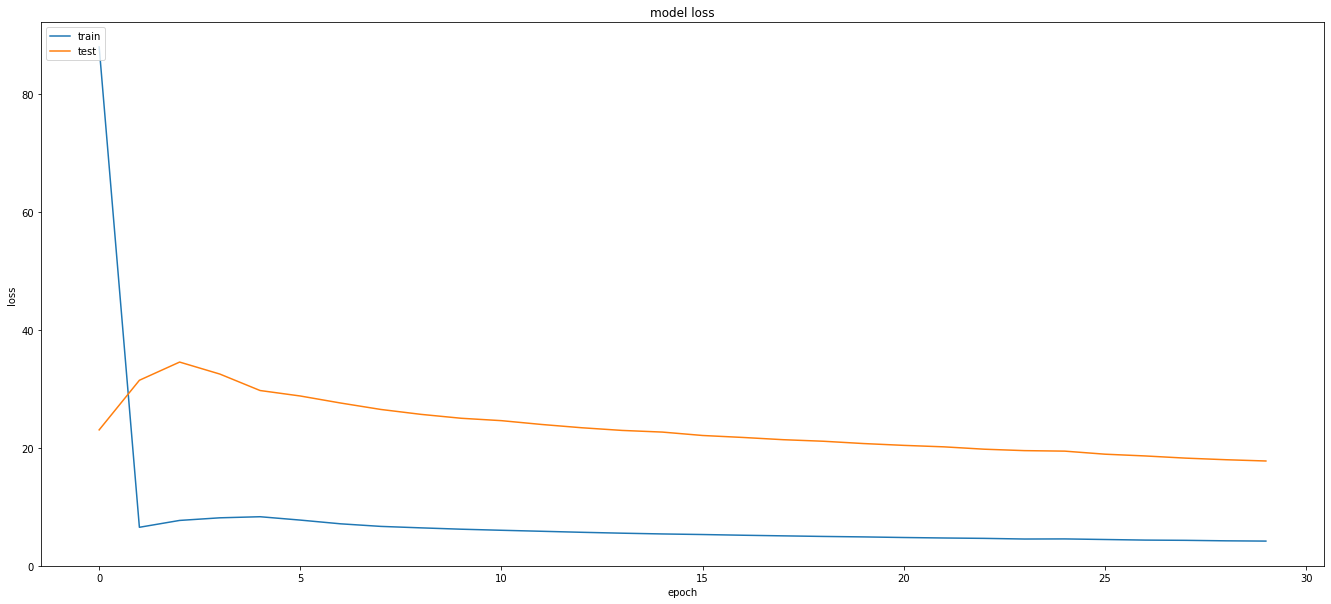

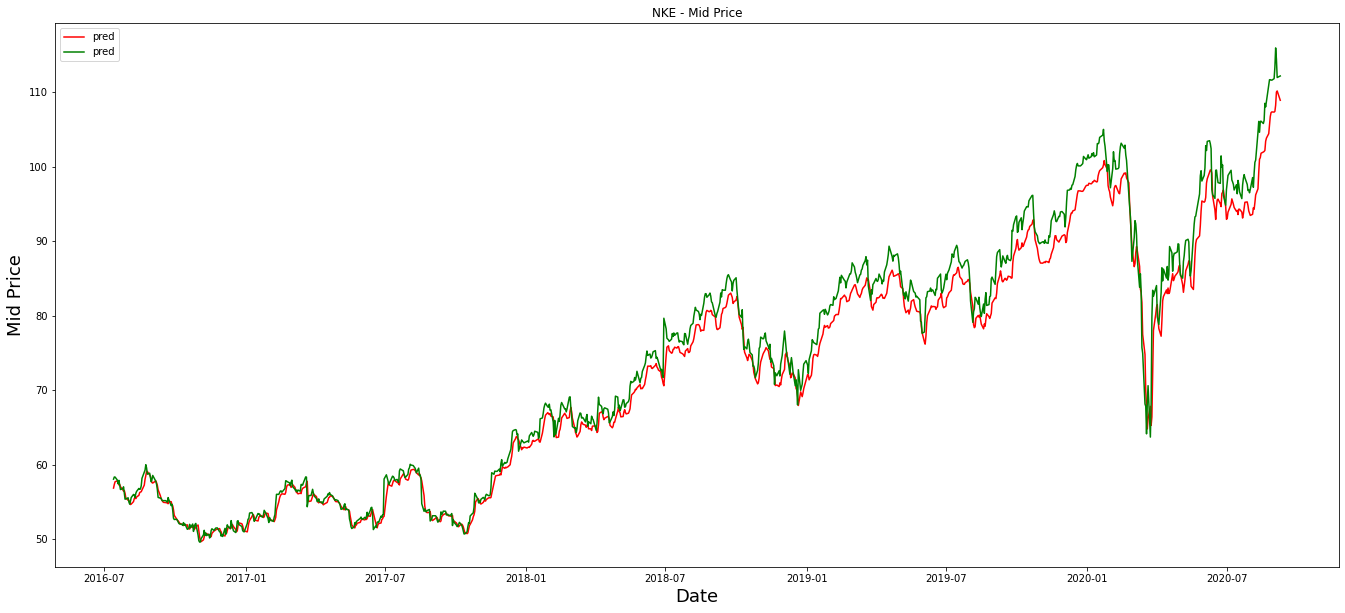

INFO:tensorflow:Assets written to: model_NKE.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 478.3136 - val_loss: 5.8993
Epoch 2/30
236/236 [==============================] - 1s 4ms/step - loss: 5.6921 - val_loss: 5.9576
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 5.8523 - val_loss: 5.3574
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 6.0746 - val_loss: 5.5941
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 6.4210 - val_loss: 5.5477
Epoch 6/30
236/236 [==============================] - 2s 7ms/step - loss: 6.7641 - val_loss: 5.2785
Epoch 7/30
236/236 [==============================] - 2s 8ms/step - loss: 6.9642 - val_loss: 5.1899
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 7.1108 - val_loss: 5.1635
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 7.1599 - val_loss: 5.2248
Epoch 10/30
236/236 [=======================

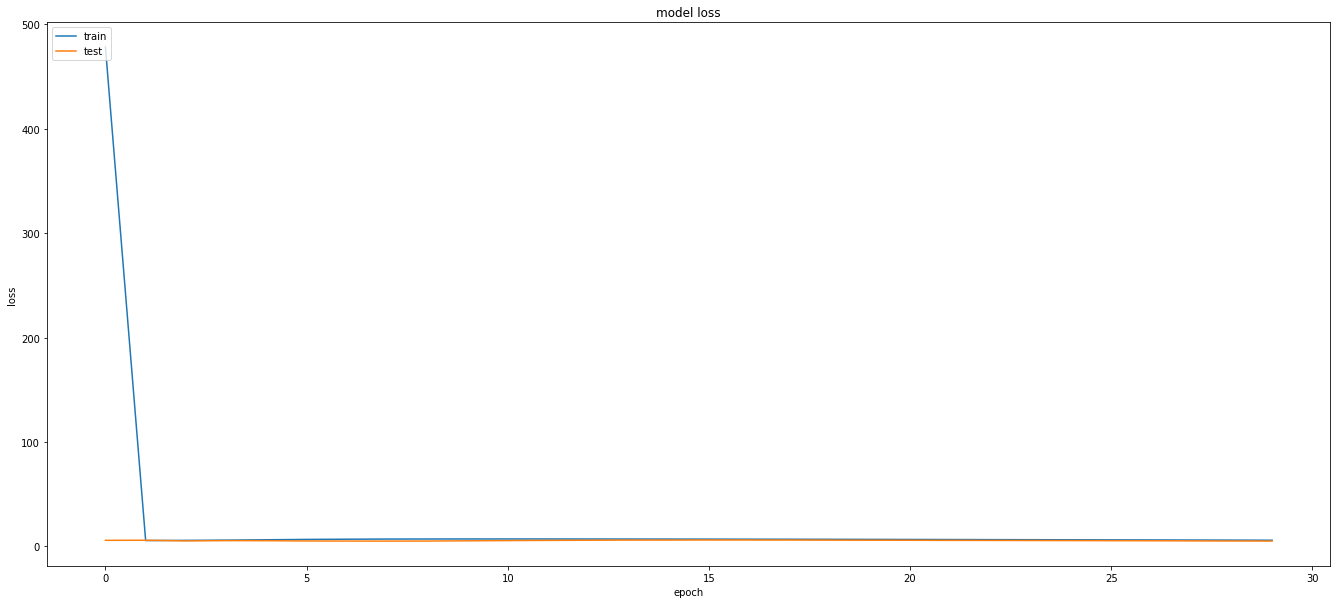

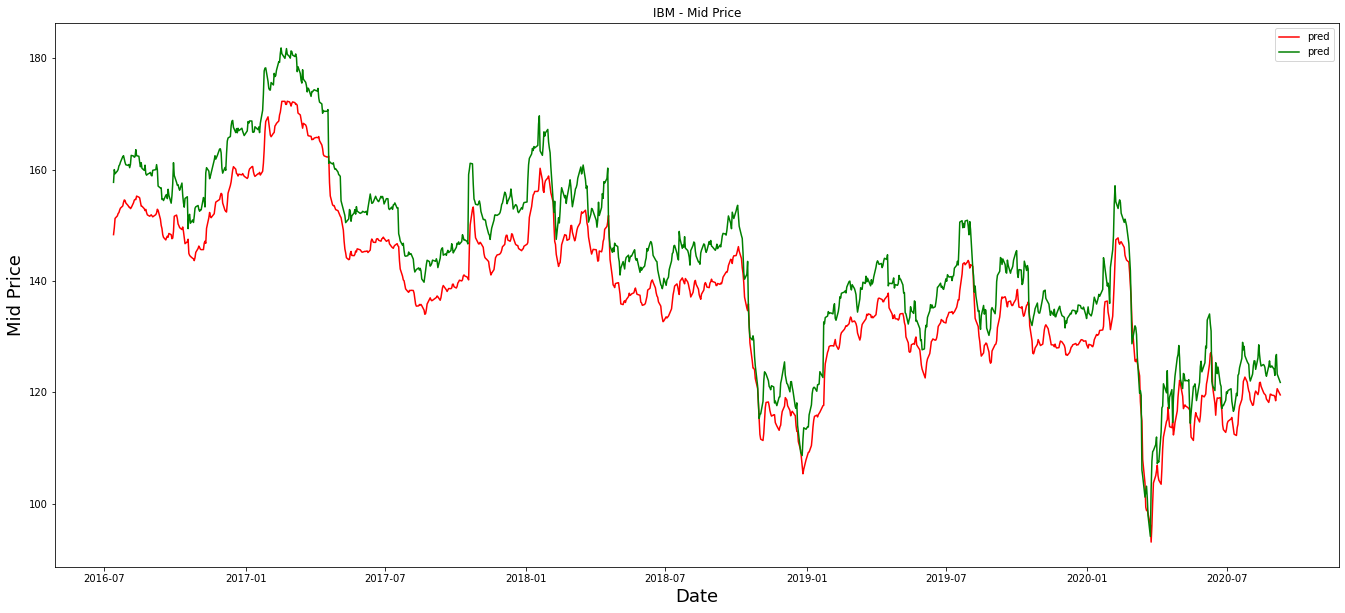

INFO:tensorflow:Assets written to: model_IBM.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 612.5192 - val_loss: 3.7081
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 7.9228 - val_loss: 1.8099
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 6.4018 - val_loss: 1.6354
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 6.0040 - val_loss: 2.7575
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 6.0282 - val_loss: 3.0118
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 5.9813 - val_loss: 4.4487
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 6.0493 - val_loss: 3.0770
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 5.9217 - val_loss: 3.8714
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 6.0279 - val_loss: 3.2362
Epoch 10/30
236/236 [=======================

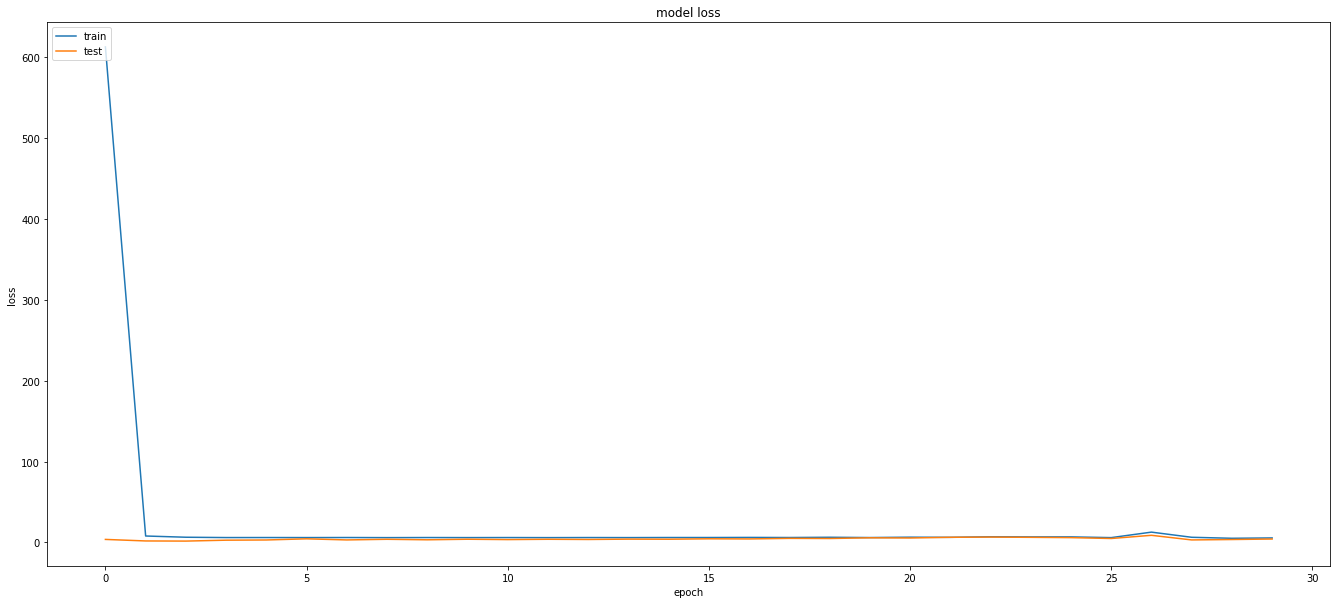

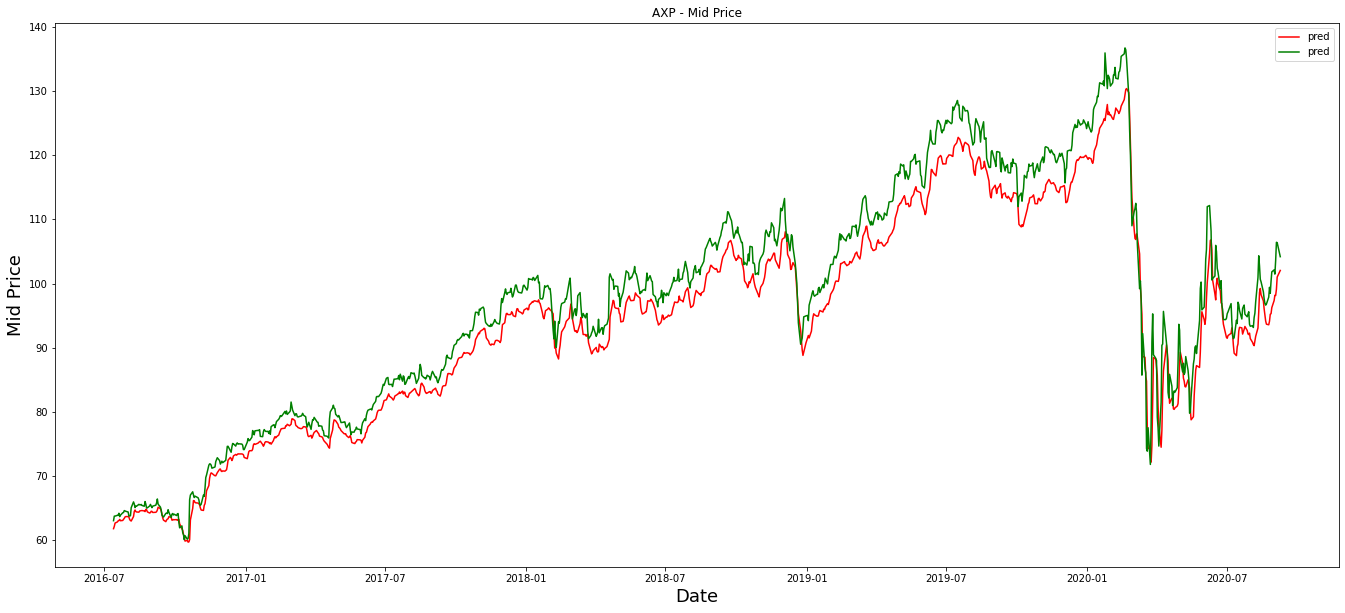

INFO:tensorflow:Assets written to: model_AXP.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 241.6997 - val_loss: 3.4382
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 4.8933 - val_loss: 3.5130
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 5.2008 - val_loss: 3.8482
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 5.7906 - val_loss: 3.8154
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 6.0586 - val_loss: 4.0902
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 6.2996 - val_loss: 4.2769
Epoch 7/30
236/236 [==============================] - 1s 6ms/step - loss: 6.4732 - val_loss: 4.1498
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 6.5127 - val_loss: 4.0613
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 6.5762 - val_loss: 3.8002
Epoch 10/30
236/236 [=======================

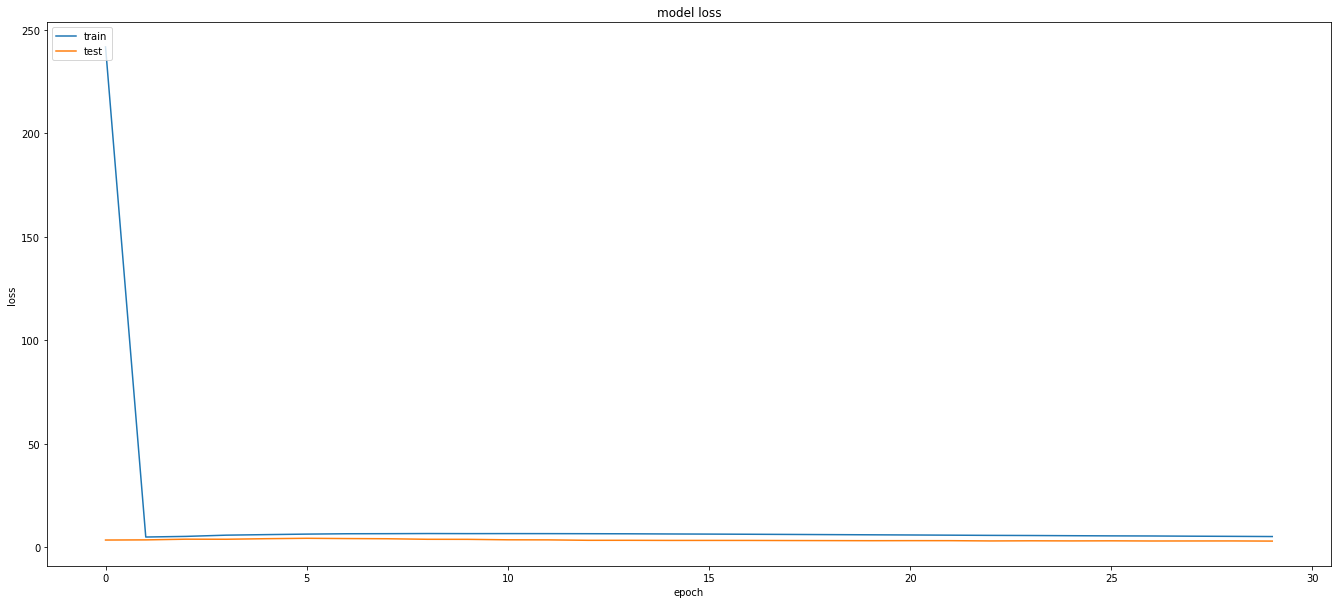

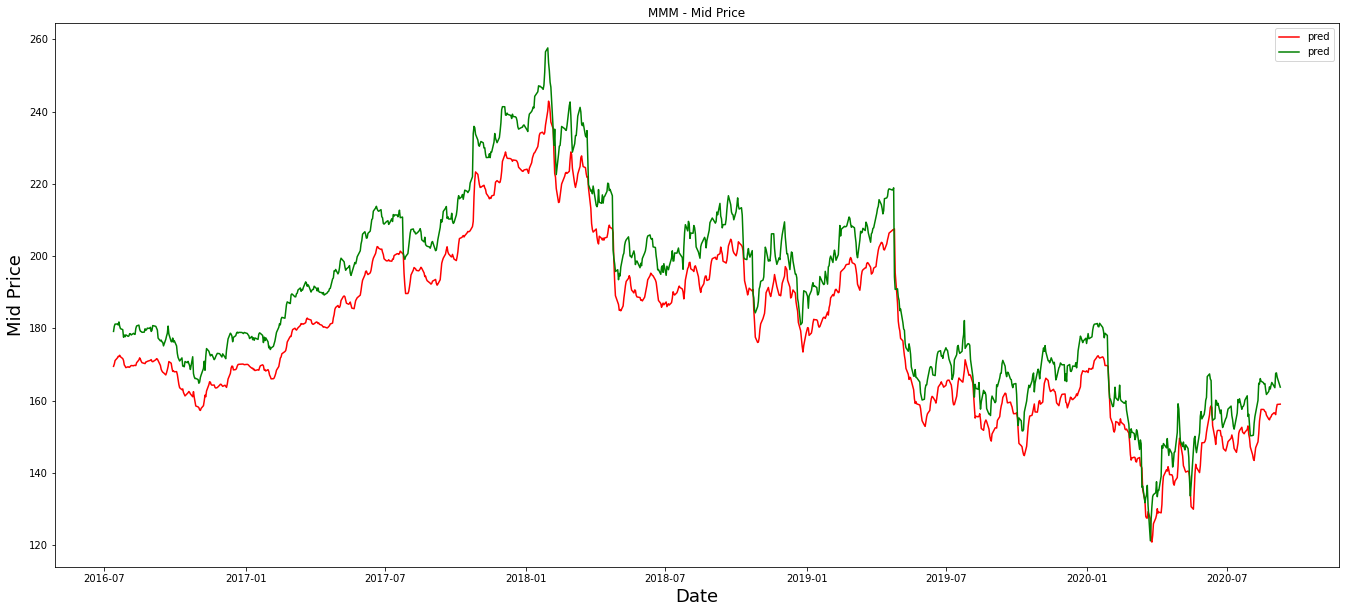

INFO:tensorflow:Assets written to: model_MMM.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 304.1738 - val_loss: 10.4820
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 15.3879 - val_loss: 11.3856
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 15.5763 - val_loss: 10.0172
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 19.2457 - val_loss: 13.1964
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 19.2132 - val_loss: 14.3643
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 19.6234 - val_loss: 15.6496
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 19.4070 - val_loss: 15.7310
Epoch 8/30
236/236 [==============================] - 1s 5ms/step - loss: 19.0665 - val_loss: 15.9457
Epoch 9/30
236/236 [==============================] - 1s 5ms/step - loss: 18.5620 - val_loss: 15.6298
Epoch 10/30
236/236 [======

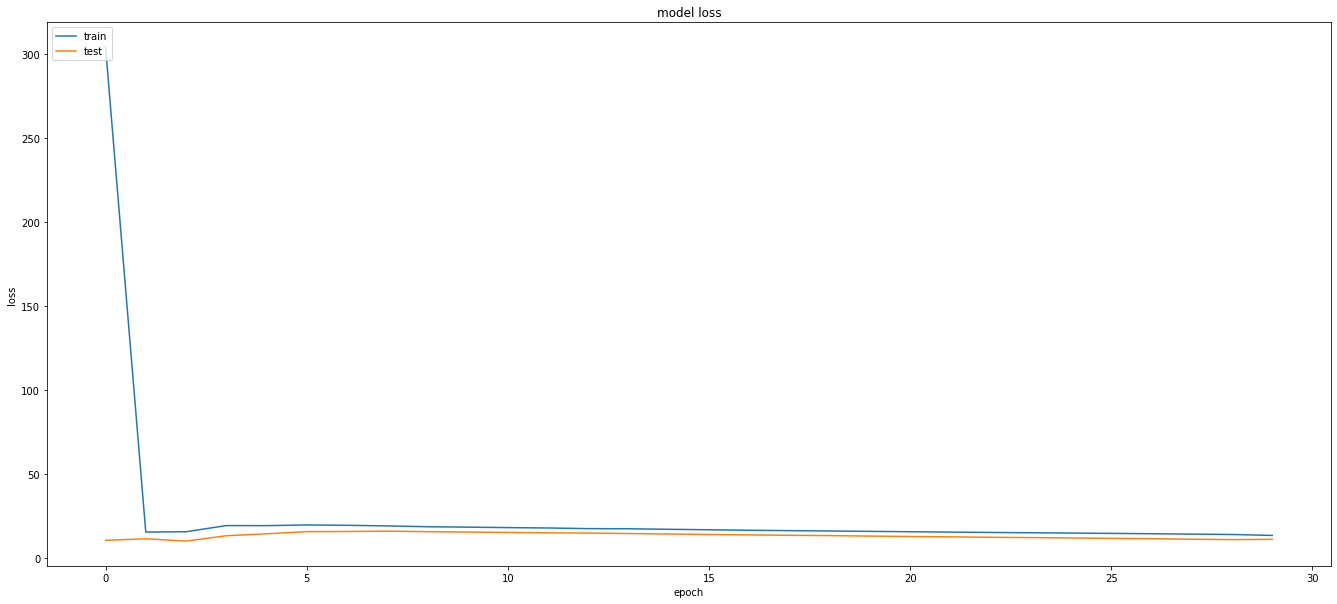

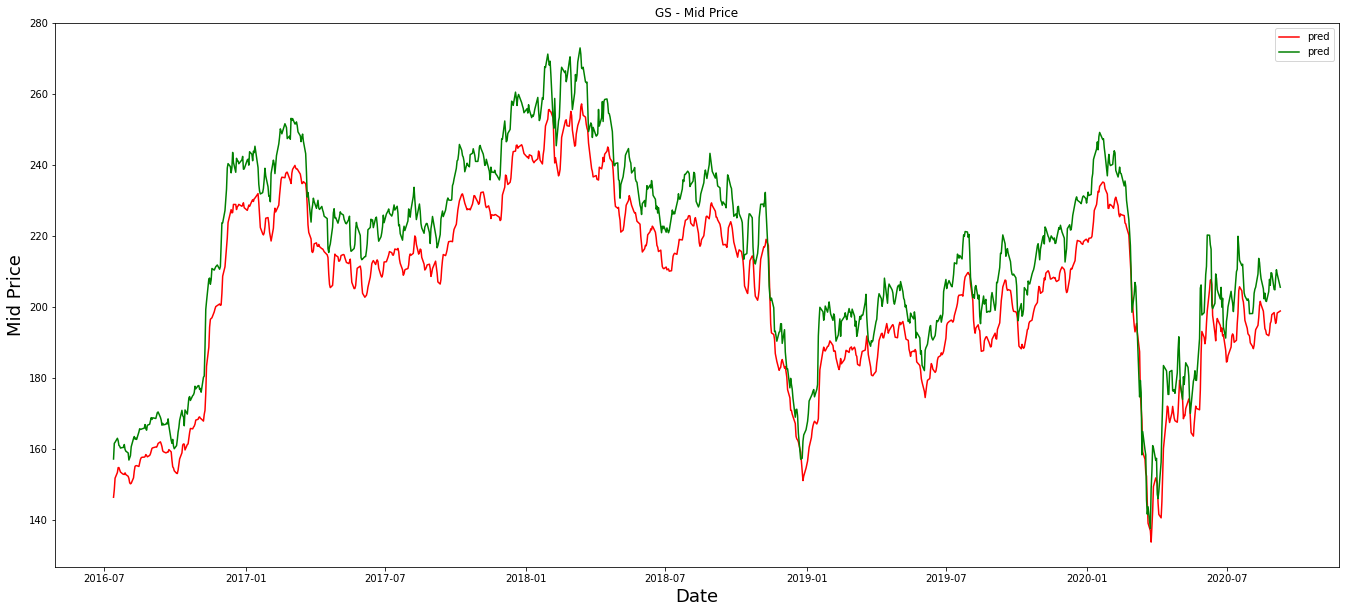

INFO:tensorflow:Assets written to: model_GS.p/assets
Epoch 1/30
236/236 [==============================] - 2s 7ms/step - loss: 73.0196 - val_loss: 2.3112
Epoch 2/30
236/236 [==============================] - 1s 6ms/step - loss: 3.8239 - val_loss: 4.3808
Epoch 3/30
236/236 [==============================] - 1s 6ms/step - loss: 5.3044 - val_loss: 13.3723
Epoch 4/30
236/236 [==============================] - 2s 6ms/step - loss: 8.3797 - val_loss: 9.7744
Epoch 5/30
236/236 [==============================] - 1s 6ms/step - loss: 10.8255 - val_loss: 7.8136
Epoch 6/30
236/236 [==============================] - 2s 7ms/step - loss: 12.1596 - val_loss: 6.3674
Epoch 7/30
236/236 [==============================] - 2s 6ms/step - loss: 9.9640 - val_loss: 4.0291
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 7.6773 - val_loss: 3.5295
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 6.9371 - val_loss: 3.5686
Epoch 10/30
236/236 [======================

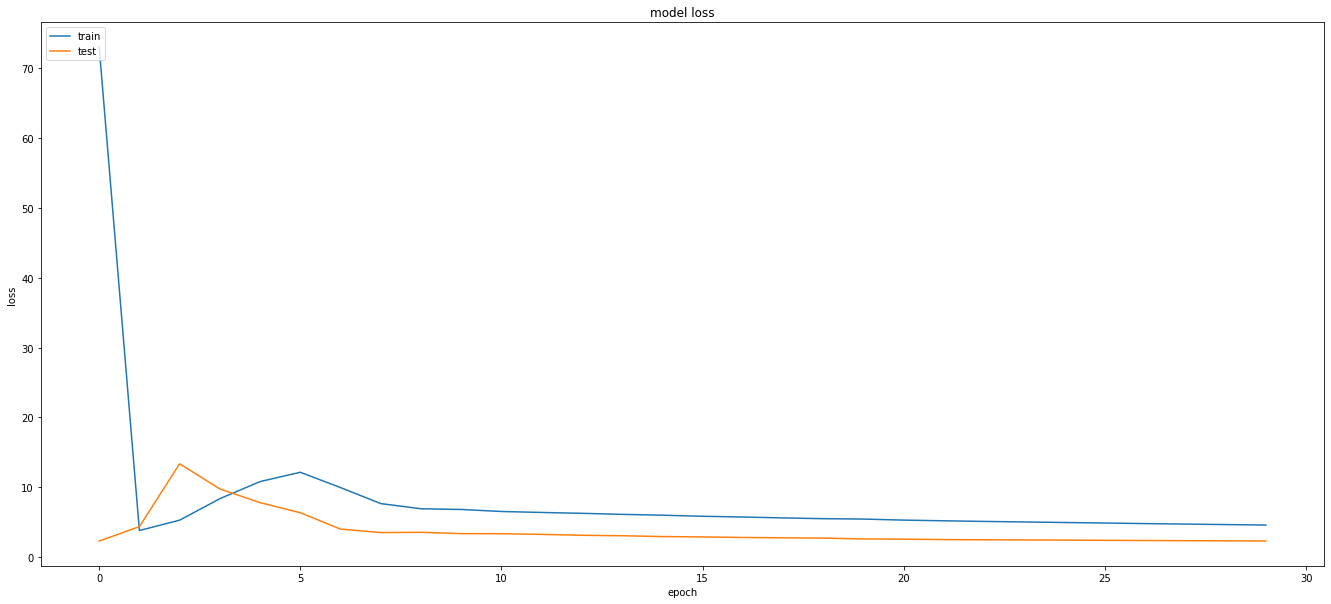

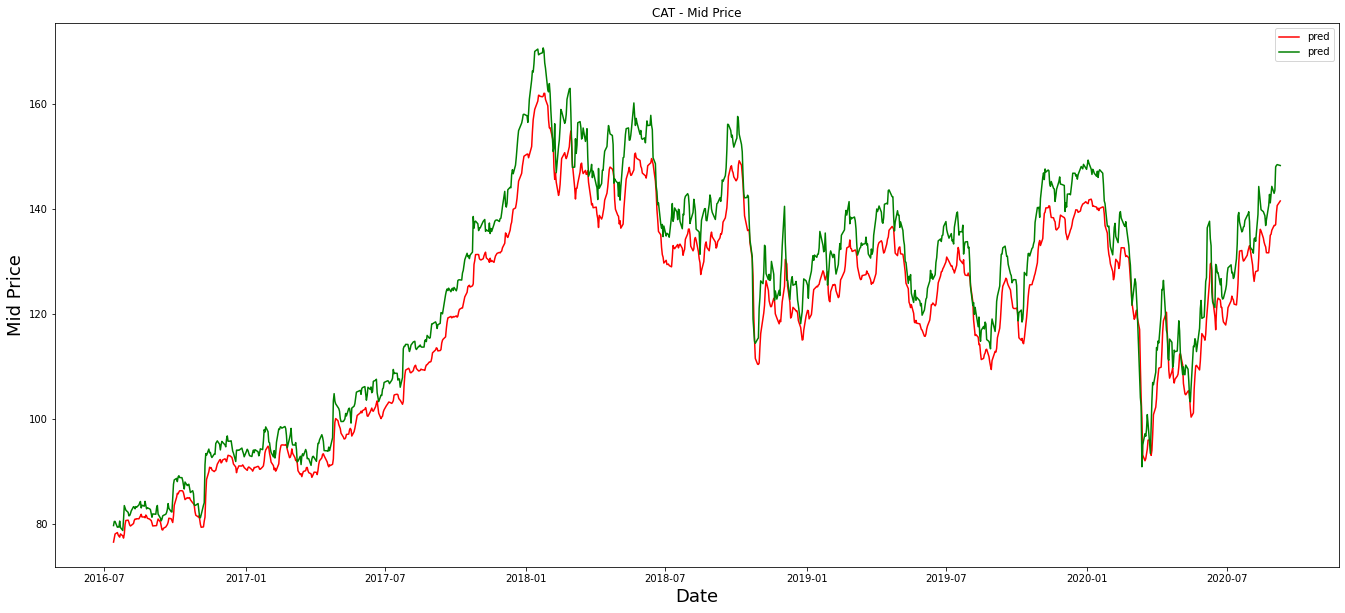

INFO:tensorflow:Assets written to: model_CAT.p/assets
Epoch 1/30
236/236 [==============================] - 2s 6ms/step - loss: 33.7008 - val_loss: 3.0349
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 1.0398 - val_loss: 3.7984
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9857 - val_loss: 5.1877
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9346 - val_loss: 4.0231
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 0.8358 - val_loss: 2.8969
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7457 - val_loss: 2.0506
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 0.7650 - val_loss: 2.0280
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 0.8429 - val_loss: 1.9785
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 0.9163 - val_loss: 2.1746
Epoch 10/30
236/236 [========================

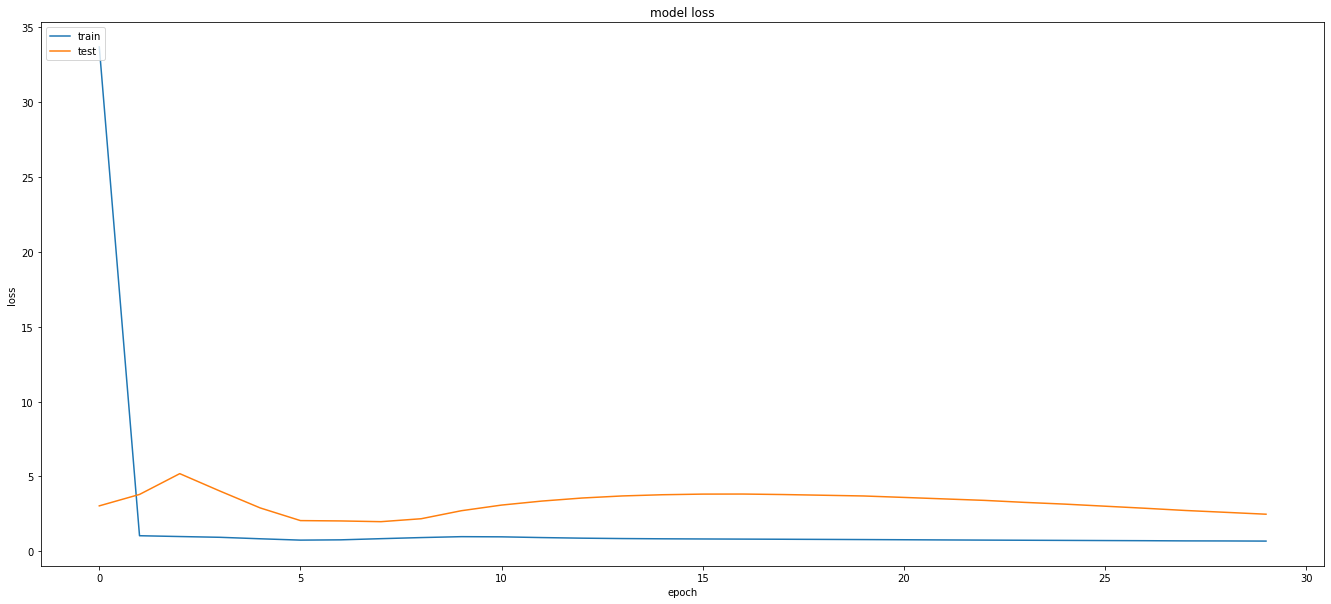

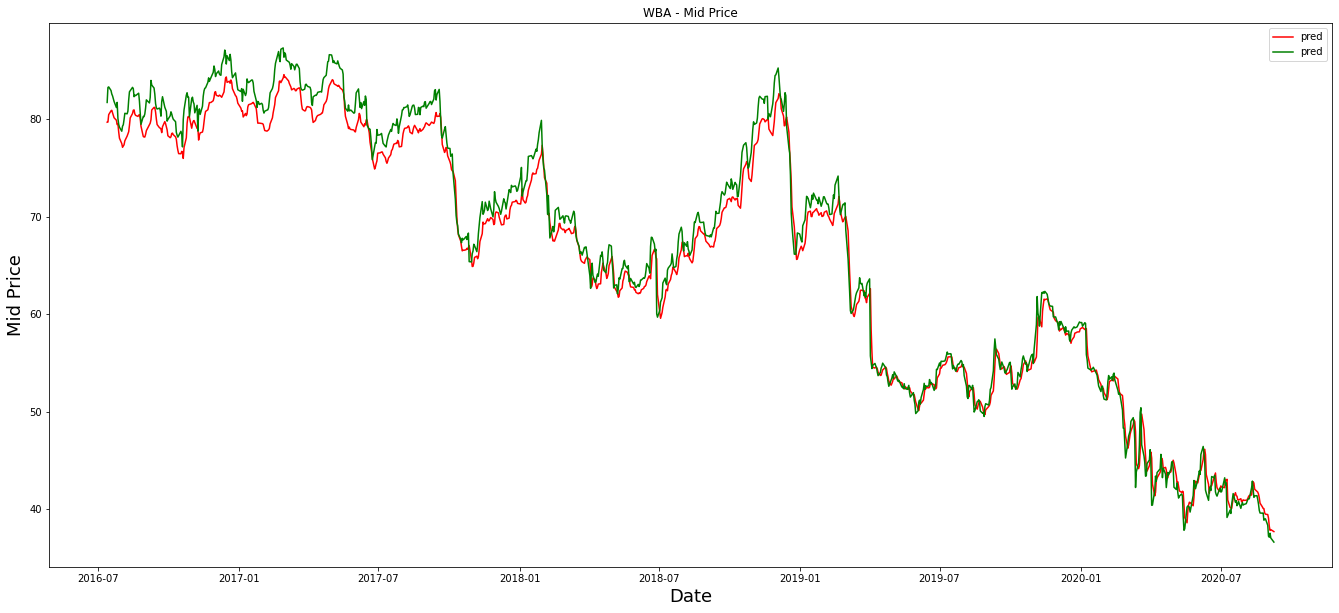

INFO:tensorflow:Assets written to: model_WBA.p/assets
Epoch 1/30
15/15 [==============================] - 0s 27ms/step - loss: 2931.3906 - val_loss: 341.2733
Epoch 2/30
15/15 [==============================] - 0s 6ms/step - loss: 191.4795 - val_loss: 57.7755
Epoch 3/30
15/15 [==============================] - 0s 6ms/step - loss: 41.4393 - val_loss: 10.4520
Epoch 4/30
15/15 [==============================] - 0s 6ms/step - loss: 24.0694 - val_loss: 26.8438
Epoch 5/30
15/15 [==============================] - 0s 6ms/step - loss: 10.0699 - val_loss: 3.1135
Epoch 6/30
15/15 [==============================] - 0s 6ms/step - loss: 6.5864 - val_loss: 9.5004
Epoch 7/30
15/15 [==============================] - 0s 6ms/step - loss: 4.6275 - val_loss: 3.2652
Epoch 8/30
15/15 [==============================] - 0s 6ms/step - loss: 3.0154 - val_loss: 4.1716
Epoch 9/30
15/15 [==============================] - 0s 6ms/step - loss: 3.4120 - val_loss: 4.1206
Epoch 10/30
15/15 [==============================]

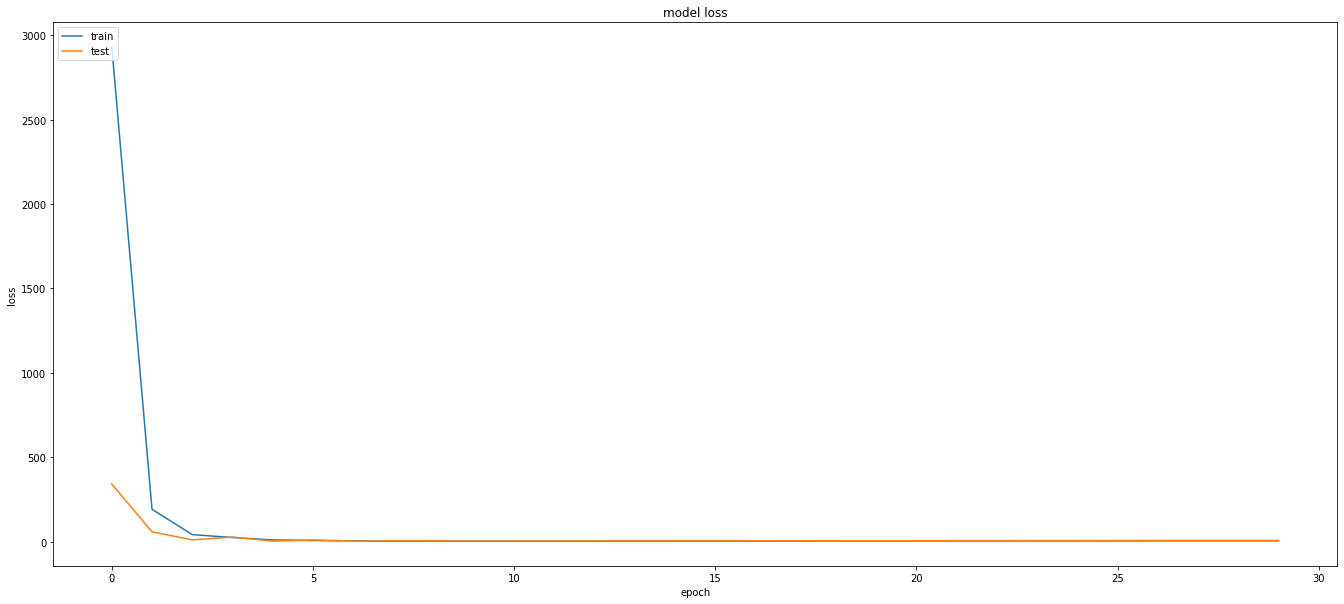

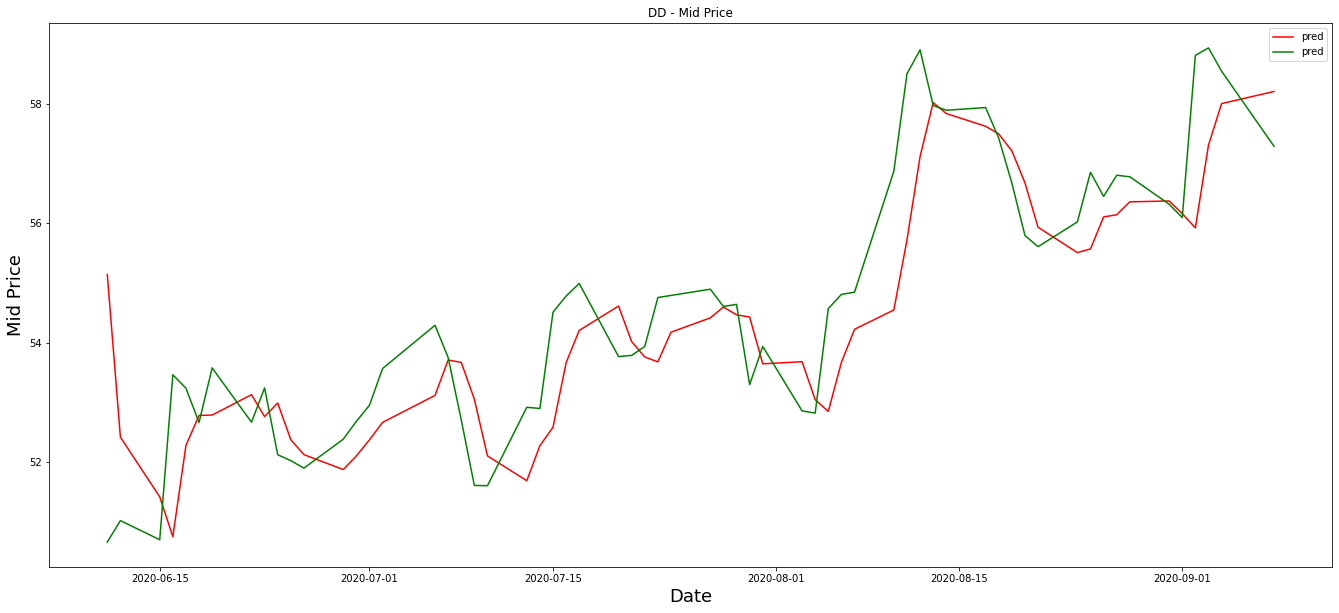

INFO:tensorflow:Assets written to: model_DD.p/assets
Epoch 1/30
236/236 [==============================] - 1s 6ms/step - loss: 60.9883 - val_loss: 2.3105
Epoch 2/30
236/236 [==============================] - 1s 5ms/step - loss: 2.0152 - val_loss: 5.9636
Epoch 3/30
236/236 [==============================] - 1s 5ms/step - loss: 1.5221 - val_loss: 4.4368
Epoch 4/30
236/236 [==============================] - 1s 5ms/step - loss: 1.2169 - val_loss: 3.0297
Epoch 5/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9747 - val_loss: 2.0996
Epoch 6/30
236/236 [==============================] - 1s 5ms/step - loss: 0.9175 - val_loss: 1.5127
Epoch 7/30
236/236 [==============================] - 1s 5ms/step - loss: 1.2201 - val_loss: 1.5413
Epoch 8/30
236/236 [==============================] - 1s 6ms/step - loss: 1.4936 - val_loss: 1.5224
Epoch 9/30
236/236 [==============================] - 1s 6ms/step - loss: 1.6799 - val_loss: 1.5000
Epoch 10/30
236/236 [=========================

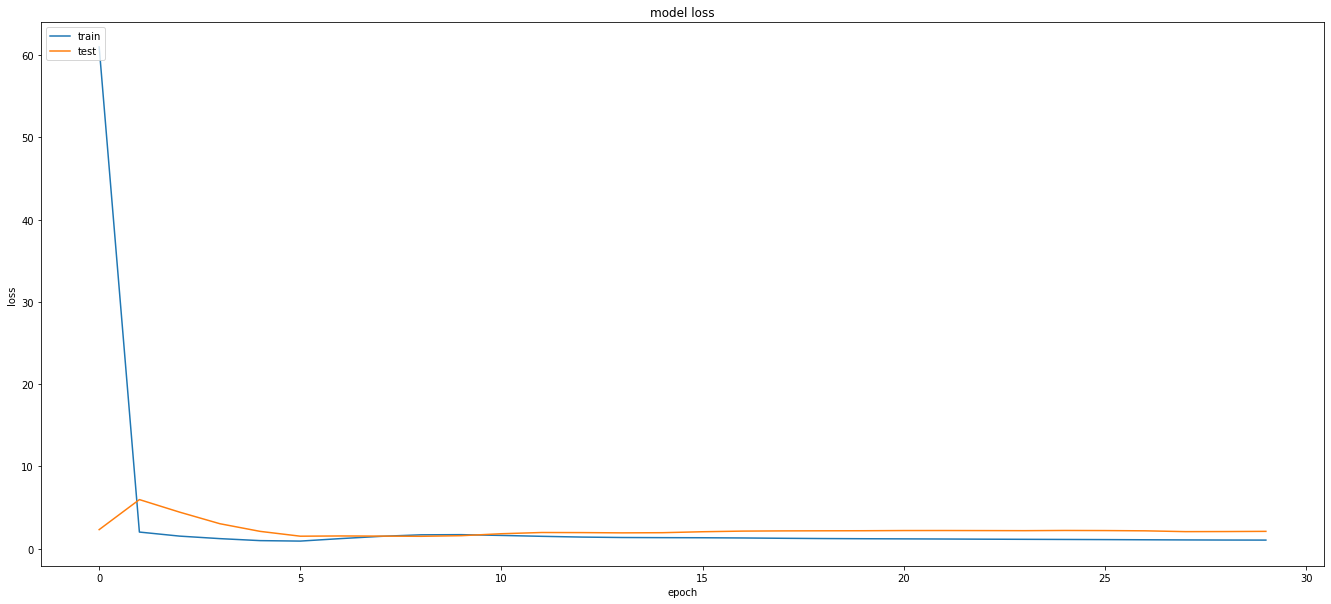

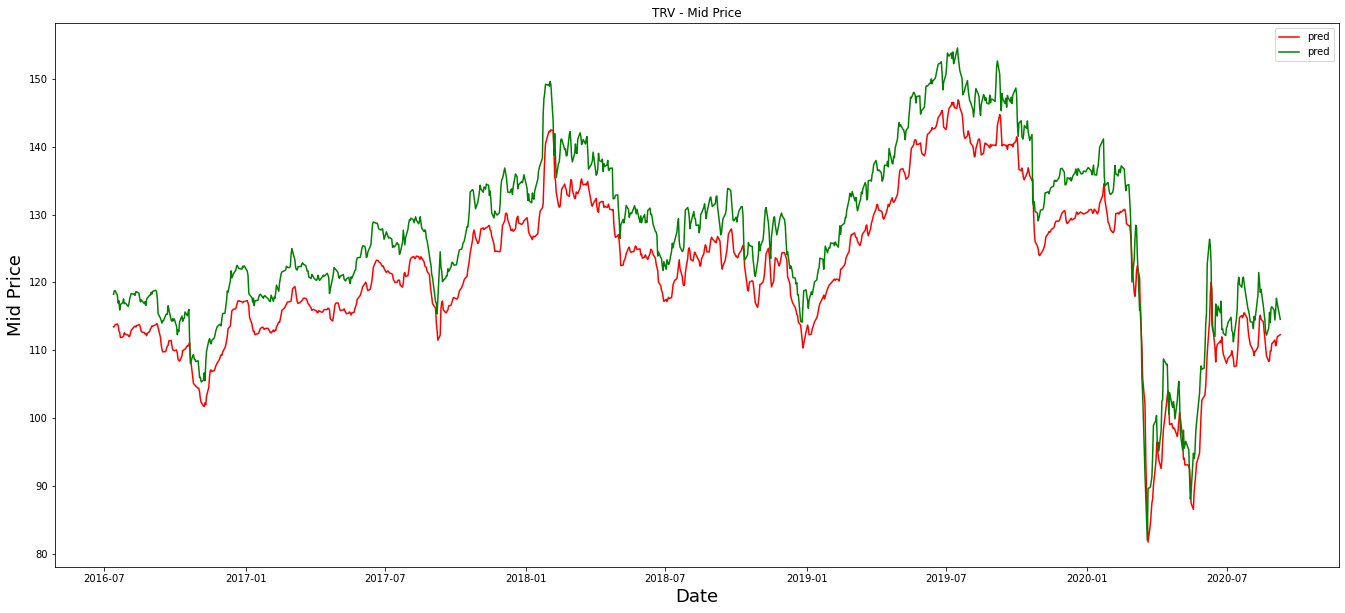

INFO:tensorflow:Assets written to: model_TRV.p/assets
Epoch 1/30
184/184 [==============================] - 1s 7ms/step - loss: 39.2001 - val_loss: 6.9932
Epoch 2/30
184/184 [==============================] - 1s 5ms/step - loss: 24.0882 - val_loss: 1.6661
Epoch 3/30
184/184 [==============================] - 1s 5ms/step - loss: 18.2422 - val_loss: 4.7091
Epoch 4/30
184/184 [==============================] - 1s 5ms/step - loss: 21.7929 - val_loss: 7.4449
Epoch 5/30
184/184 [==============================] - 1s 5ms/step - loss: 23.0482 - val_loss: 2.5040
Epoch 6/30
184/184 [==============================] - 1s 5ms/step - loss: 20.9117 - val_loss: 2.5300
Epoch 7/30
184/184 [==============================] - 1s 5ms/step - loss: 19.8337 - val_loss: 2.6392
Epoch 8/30
184/184 [==============================] - 1s 5ms/step - loss: 19.4061 - val_loss: 2.5340
Epoch 9/30
184/184 [==============================] - 1s 5ms/step - loss: 18.0953 - val_loss: 2.3702
Epoch 10/30
184/184 [================

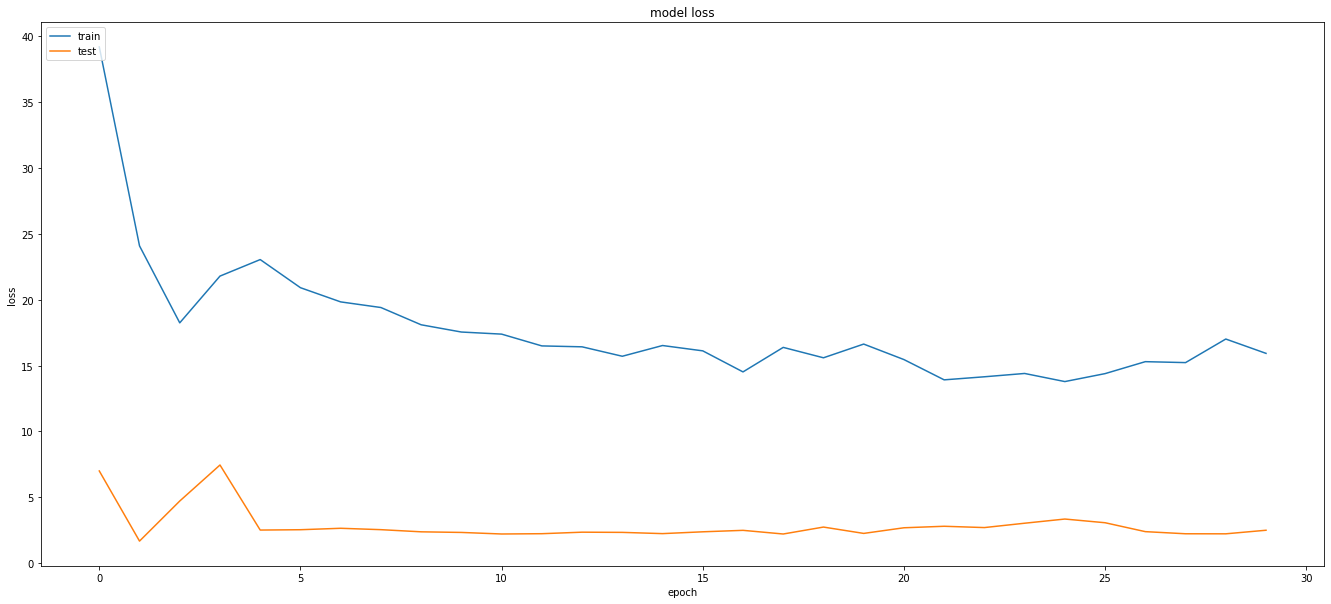

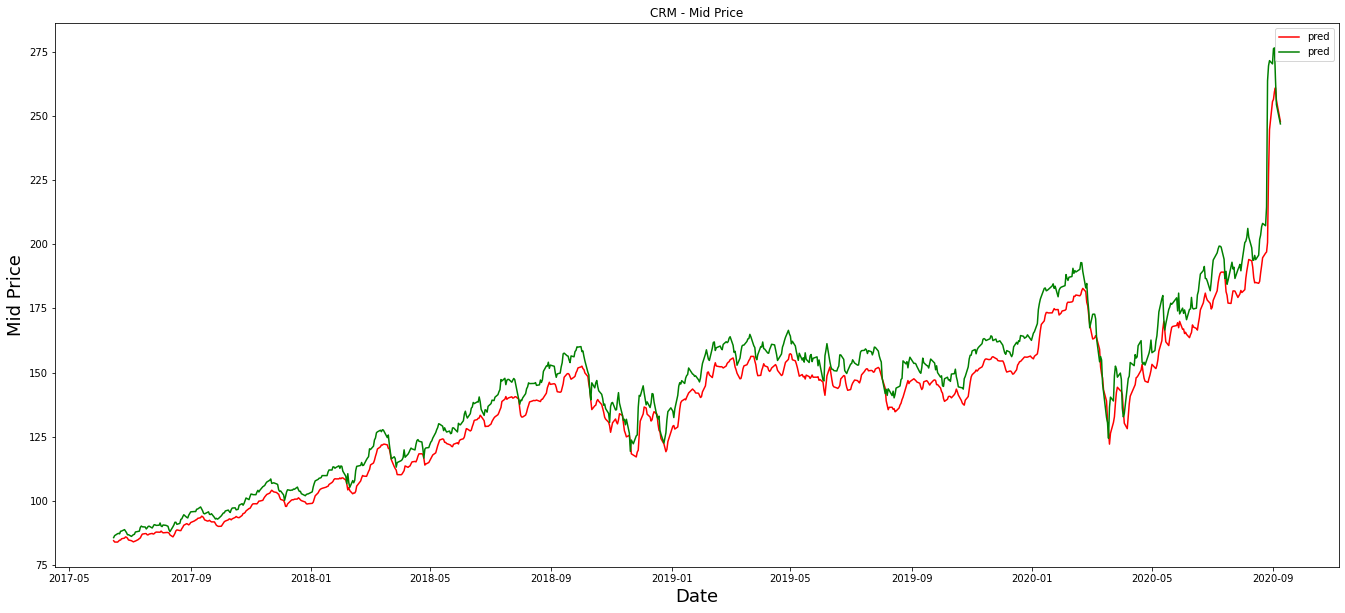

INFO:tensorflow:Assets written to: model_CRM.p/assets


In [458]:
export_models(symbols[2:], df_timeseries)